<a href="https://colab.research.google.com/github/22022658NguyenTienKhoi/13-Weather-Forecast/blob/main/prophet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Dự báo nhiệt độ bằng fb prophet**

In [2]:
import pandas as pd
import numpy as np
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import TimeSeriesSplit
from scipy import stats
from collections import Counter
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_absolute_error,mean_absolute_percentage_error,mean_squared_error,r2_score

In [62]:
weather = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/hanoiweather.csv")

In [4]:
weather

,name,datetime,tempmax,tempmin,temp,feelslikemax,feelslikemin,feelslike,dew,humidity,...,solarenergy,uvindex,severerisk,sunrise,sunset,moonphase,conditions,description,icon,stations
0,Hà Nội,1990-01-01,15.9,13.4,14.6,15.9,13.4,14.6,14.0,96.3,...,NaN,NaN,NaN,1990-01-01T06:33:41,1990-01-01T17:26:18,0.14,Overcast,Cloudy skies throughout the day.,cloudy,48820099999
1,Hà Nội,1990-01-02,17.4,14.6,16.1,17.4,14.6,16.1,13.7,85.9,...,NaN,NaN,NaN,1990-01-02T06:34:00,1990-01-02T17:26:56,0.18,Overcast,Cloudy skies throughout the day.,cloudy,48820099999
2,Hà Nội,1990-01-03,18.2,16.1,16.8,18.2,16.1,16.8,13.8,82.5,...,NaN,NaN,NaN,1990-01-03T06:34:18,1990-01-03T17:27:34,0.22,Overcast,Cloudy skies throughout the day.,cloudy,48820099999
3,Hà Nội,1990-01-04,19.6,15.2,16.4,19.6,15.2,16.4,14.3,88.2,...,NaN,NaN,NaN,1990-01-04T06:34:35,1990-01-04T17:28:12,0.25,Overcast,Cloudy skies throughout the day.,cloudy,48820099999
4,Hà Nội,1990-01-05,18.1,15.4,16.9,18.1,15.4,16.9,15.8,93.8,...,NaN,NaN,NaN,1990-01-05T06:34:51,1990-01-05T17:28:51,0.29,Overcast,Cloudy skies throughout the day.,cloudy,48820099999
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12550,Hà Nội,2024-05-12,34.0,24.6,28.5,43.5,24.6,33.1,25.5,84.8,...,19.8,7.0,60.0,2024-05-12T05:20:10,2024-05-12T18:26:03,0.13,"Rain, Partially cloudy",Partly cloudy throughout the day with late aft...,rain,"48820099999,48823099999,48825099999,4883109999..."
12551,Hà Nội,2024-05-13,30.1,23.0,26.7,33.9,23.0,28.5,22.9,80.9,...,23.7,10.0,10.0,2024-05-13T05:19:44,2024-05-13T18:26:28,0.16,"Rain, Partially cloudy",Partly cloudy throughout the day with a chance...,rain,"48820099999,48823099999,48825099999,4883109999..."
12552,Hà Nội,2024-05-14,32.0,24.0,28.0,37.8,24.0,31.0,23.8,78.7,...,21.0,9.0,30.0,2024-05-14T05:19:18,2024-05-14T18:26:54,0.20,"Rain, Partially cloudy",Partly cloudy throughout the day with a chance...,rain,"48820099999,48823099999,48825099999,4883109999..."
12553,Hà Nội,2024-05-15,31.0,24.0,27.4,39.0,24.0,30.5,25.0,87.7,...,19.1,8.0,30.0,2024-05-15T05:18:54,2024-05-15T18:27:19,0.25,"Rain, Partially cloudy",Partly cloudy throughout the day with rain.,rain,VVNB


#Xử lý và phân tích dữ liệu, gắn nhãn cho dữ liệu

Xử lý dữ liệu đầu vào

In [63]:
from datetime import datetime

def time_to_minutes(time_str):
    # Định nghĩa các định dạng thời gian khác nhau
    formats = ["%Y-%m-%dT%H:%M:%S", "%Y-%m-%d %H:%M:%S"]

    for fmt in formats:
        try:
            # Cố gắng phân tích chuỗi thời gian với từng định dạng
            time_obj = datetime.strptime(time_str, fmt)
            return time_obj.hour * 60 + time_obj.minute
        except ValueError:
            # Nếu định dạng không khớp, thử định dạng tiếp theo
            continue

    # Nếu không có định dạng nào khớp, in lỗi
    raise ValueError(f"Thời gian '{time_str}' không khớp với bất kỳ định dạng nào đã biết")

# Biến đổi thời gian của sunrise và sunset
weather['sunrise_minutes'] = weather['sunrise'].apply(time_to_minutes)
weather['sunset_minutes'] = weather['sunset'].apply(time_to_minutes)

In [64]:
weather.set_index('datetime',inplace = True)

In [65]:
def conditions_encode(dataset):
  conditions_encoded = pd.get_dummies(dataset['conditions'], prefix='cond')
  return conditions_encoded

In [66]:
# Mã hoá Conditions vì là dữ liệu phân loại
conditions_encoded = conditions_encode(weather)
weather= pd.concat([weather, conditions_encoded], axis=1)

In [67]:
features = ['tempmax', 'tempmin', 'humidity', 'cloudcover', 'windspeed', 'sealevelpressure', 'moonphase', 'visibility', 'winddir', 'feelslikemax' ,'feelslikemin','feelslike', 'dew', 'temp', 'sunrise_minutes', 'sunset_minutes',]

In [68]:
#Thêm condition vào features
def add_features(dataset):
  condition_features = [col for col in dataset.columns if 'cond_' in col]
  features.extend(condition_features)
  return features

Xác định các biến độc lập

In [69]:
weather = weather[add_features(weather)]

In [70]:
# Clean invalid columns
null = weather.apply(pd.isnull).sum()

In [71]:
null

tempmax                        57
tempmin                        57
humidity                       57
cloudcover                     57
windspeed                       0
sealevelpressure               99
moonphase                       0
visibility                     57
winddir                        78
feelslikemax                   57
feelslikemin                   57
feelslike                      57
dew                            57
temp                           57
sunrise_minutes                 0
sunset_minutes                  0
cond_Clear                      0
cond_Overcast                   0
cond_Partially cloudy           0
cond_Rain                       0
cond_Rain, Overcast             0
cond_Rain, Partially cloudy     0
dtype: int64

In [72]:
valid_columns = weather.columns[null < 100]

In [73]:
weather = weather.dropna(subset=features)
weather = weather[valid_columns].copy()
weather.columns = weather.columns.str.lower()

In [74]:
weather.index = pd.to_datetime(weather.index)

Xác định mục tiêu dự đoán là nhiệt độ ngày kế tiếp.Gắn nhãn cho data

In [75]:
# Setup time series for prophet
weather["y"] = weather.shift(-1)['tempmax']
weather = weather.ffill()

In [76]:
weather["ds"] = weather.index

Xử lý bỏ những điểm nhiệt độ biến động được coi là nhiễu

In [77]:
def calculate_contamination(data, outlier_factor=1.5):
    # Calculate quartiles
    Q1 = np.percentile(data, 25)
    Q3 = np.percentile(data, 75)

    # Calculate IQR
    IQR = Q3 - Q1

    # Define outlier thresholds
    lower_threshold = Q1 - outlier_factor * IQR
    upper_threshold = Q3 + outlier_factor * IQR

    # Identify outliers
    outliers = (data < lower_threshold) | (data > upper_threshold)
    num_outliers = np.sum(outliers)

    # Calculate contamination percentage
    contamination = (num_outliers / len(data))

    return contamination

In [78]:
contaminate = calculate_contamination(weather['tempmax'])

In [79]:
contaminate

0.0019300361881785283

In [80]:
iso_forest = IsolationForest(contamination=contaminate)  # Adjust contamination parameter as needed
anomaly_labels = iso_forest.fit_predict(weather[['y']])

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning:

X does not have valid feature names, but IsolationForest was fitted with feature names



In [81]:
weather = weather[anomaly_labels == 1]

Phân chia dữ liệu thành bộ huấn luyện, bộ đánh giá và bộ test

In [83]:
test = weather['2024-04-30':]
weather = weather[:'2024-04-30']
train = weather[:'2017-12-31']
val = weather['2018-01-01':]

Naive approach:
assume that tempmax_t+1 = tempmax_t

In [25]:
se = ((weather['y'] - weather['tempmax']) ** 2)
print(se.mean())

6.502091972569585


In [26]:
ae = abs((weather['y'] - weather['tempmax']))
print(ae.mean())

1.8720371117386043


Apply FB prophet:
aim to beat the baseline mse=6.5 and mae = 1.87

In [27]:
train

,tempmax,tempmin,humidity,cloudcover,windspeed,sealevelpressure,moonphase,visibility,winddir,feelslikemax,...,sunrise_minutes,sunset_minutes,cond_clear,cond_overcast,cond_partially cloudy,cond_rain,"cond_rain, overcast","cond_rain, partially cloudy",y,ds
datetime,,,,,,,,,,,,,,,,,,,,,
1990-01-01,15.9,13.4,96.3,100.0,7.2,1015.9,0.14,10.0,24.1,15.9,...,393,1046,False,True,False,False,False,False,17.4,1990-01-01
1990-01-02,17.4,14.6,85.9,100.0,7.2,1019.0,0.18,17.1,25.0,17.4,...,394,1046,False,True,False,False,False,False,18.2,1990-01-02
1990-01-03,18.2,16.1,82.5,100.0,7.2,1019.7,0.22,19.9,25.0,18.2,...,394,1047,False,True,False,False,False,False,19.6,1990-01-03
1990-01-04,19.6,15.2,88.2,100.0,7.2,1019.0,0.25,9.7,50.0,19.6,...,394,1048,False,True,False,False,False,False,18.1,1990-01-04
1990-01-05,18.1,15.4,93.8,98.6,3.6,1018.5,0.29,11.4,50.0,18.1,...,394,1048,False,True,False,False,False,False,17.7,1990-01-05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-12-27,17.0,14.0,89.0,68.4,12.1,1021.3,0.30,4.5,317.1,17.0,...,391,1043,False,False,False,False,False,True,18.2,2017-12-27
2017-12-28,18.2,14.0,89.5,74.2,8.5,1020.8,0.34,5.7,2.9,18.2,...,392,1043,False,False,False,False,False,True,19.2,2017-12-28
2017-12-29,19.2,16.0,88.4,81.1,9.4,1020.3,0.37,4.2,24.6,19.2,...,392,1044,False,False,False,False,False,True,20.0,2017-12-29


In [28]:
weather['tempmax'].max()

43.1

In [29]:
weather['tempmax'].min()

8.1

#Tối ưu hoá các hyperparameter bằng phương pháp grid search

In [30]:
def get_predictors(dataset):
  predictors = dataset.columns[~dataset.columns.isin(['y','ds'])]
  return predictors

In [36]:
from sklearn.model_selection import ParameterGrid
params_grid = {
                'changepoint_prior_scale':[0.002,0.004,0.008],
                'n_changepoints' : [10,25,50],
                'seasonality_prior_scale':[0.05,0.1,0.2],
                'period':[720,1080,1440,1800],
                'fourier_order':[1,2,3,4,5],
              }
grid = ParameterGrid(params_grid)
cnt = 0
for p in grid:
    cnt = cnt+1

print('Total Possible Models',cnt)

Total Possible Models 540


In [37]:
import random
from prophet import Prophet
model_parameters = pd.DataFrame(columns=['MSE', 'Parameters'])

i = 0
for p in grid:
    print(f"Iteration: {i+1}/{len(grid)}")
    print(p)
    random.seed(0)

    # Initialize Prophet with the current set of parameters
    train_model = Prophet(changepoint_prior_scale=p['changepoint_prior_scale'],
                          n_changepoints=p['n_changepoints'],
                          daily_seasonality=False,
                          weekly_seasonality= False,
                          yearly_seasonality=True,
                          interval_width=0.95)
    for predictor in get_predictors(train):
        train_model.add_regressor(predictor)
    train_model.add_seasonality(name = 'periodly', period = p['period'],fourier_order = p['fourier_order'])
    # Assuming X_train and X_val are properly prepared DataFrames with 'ds' and 'y' columns
    train_model.fit(train)
    train_forecast = train_model.predict(val)

    # Extract forecasted values
    val_tune = train_forecast[['ds', 'yhat']]
    Actual = val  # Assuming X_val contains actual values

    # Calculate MSE
    mse = mean_squared_error(Actual['y'], val_tune['yhat'])
    print('MSE:', mse)

    # Append results to model_parameters DataFrame
    new_data = {'MSE': mse, 'Parameters': p}
    model_parameters = pd.concat([model_parameters, pd.DataFrame([new_data])], ignore_index=True)

    print()
    i += 1

print("Parameter tuning completed.")
print(model_parameters.head())

Iteration: 1/540
{'changepoint_prior_scale': 0.002, 'fourier_order': 1, 'n_changepoints': 10, 'period': 720, 'seasonality_prior_scale': 0.05}


DEBUG:cmdstanpy:input tempfile: /tmp/tmp48cuqejq/i6wb7flh.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp48cuqejq/6ises6dx.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=68552', 'data', 'file=/tmp/tmp48cuqejq/i6wb7flh.json', 'init=/tmp/tmp48cuqejq/6ises6dx.json', 'output', 'file=/tmp/tmp48cuqejq/prophet_modeljt4snf0m/prophet_model-20240516073220.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:32:20 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:32:21 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp48cuqejq/gd35cnfg.json


MSE: 4.930547630246564

Iteration: 2/540
{'changepoint_prior_scale': 0.002, 'fourier_order': 1, 'n_changepoints': 10, 'period': 720, 'seasonality_prior_scale': 0.1}


DEBUG:cmdstanpy:input tempfile: /tmp/tmp48cuqejq/z5h0y6vr.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=84010', 'data', 'file=/tmp/tmp48cuqejq/gd35cnfg.json', 'init=/tmp/tmp48cuqejq/z5h0y6vr.json', 'output', 'file=/tmp/tmp48cuqejq/prophet_modelsodxfw48/prophet_model-20240516073223.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:32:23 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:32:25 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


MSE: 4.930547630246564

Iteration: 3/540
{'changepoint_prior_scale': 0.002, 'fourier_order': 1, 'n_changepoints': 10, 'period': 720, 'seasonality_prior_scale': 0.2}


DEBUG:cmdstanpy:input tempfile: /tmp/tmp48cuqejq/ffwwdyda.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp48cuqejq/3hek6ol2.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=32678', 'data', 'file=/tmp/tmp48cuqejq/ffwwdyda.json', 'init=/tmp/tmp48cuqejq/3hek6ol2.json', 'output', 'file=/tmp/tmp48cuqejq/prophet_modeltj83bx7o/prophet_model-20240516073228.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:32:28 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:32:30 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp48cuqejq/8hx7eosf.json


MSE: 4.930547630246564

Iteration: 4/540
{'changepoint_prior_scale': 0.002, 'fourier_order': 1, 'n_changepoints': 10, 'period': 1080, 'seasonality_prior_scale': 0.05}


DEBUG:cmdstanpy:input tempfile: /tmp/tmp48cuqejq/txl8iov9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=95057', 'data', 'file=/tmp/tmp48cuqejq/8hx7eosf.json', 'init=/tmp/tmp48cuqejq/txl8iov9.json', 'output', 'file=/tmp/tmp48cuqejq/prophet_model_x_3sja9/prophet_model-20240516073232.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:32:32 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:32:34 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


MSE: 4.966583649987209

Iteration: 5/540
{'changepoint_prior_scale': 0.002, 'fourier_order': 1, 'n_changepoints': 10, 'period': 1080, 'seasonality_prior_scale': 0.1}


DEBUG:cmdstanpy:input tempfile: /tmp/tmp48cuqejq/4pvn_ycw.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp48cuqejq/qrgphama.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=14507', 'data', 'file=/tmp/tmp48cuqejq/4pvn_ycw.json', 'init=/tmp/tmp48cuqejq/qrgphama.json', 'output', 'file=/tmp/tmp48cuqejq/prophet_modelgaeqcslu/prophet_model-20240516073236.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:32:36 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:32:38 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp48cuqejq/rdf48ngj.json


MSE: 4.966583649987209

Iteration: 6/540
{'changepoint_prior_scale': 0.002, 'fourier_order': 1, 'n_changepoints': 10, 'period': 1080, 'seasonality_prior_scale': 0.2}


DEBUG:cmdstanpy:input tempfile: /tmp/tmp48cuqejq/t7ukblxa.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=11382', 'data', 'file=/tmp/tmp48cuqejq/rdf48ngj.json', 'init=/tmp/tmp48cuqejq/t7ukblxa.json', 'output', 'file=/tmp/tmp48cuqejq/prophet_modelc3tffg8t/prophet_model-20240516073240.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:32:40 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:32:42 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


MSE: 4.966583649987209

Iteration: 7/540
{'changepoint_prior_scale': 0.002, 'fourier_order': 1, 'n_changepoints': 10, 'period': 1440, 'seasonality_prior_scale': 0.05}


DEBUG:cmdstanpy:input tempfile: /tmp/tmp48cuqejq/guhrv60c.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp48cuqejq/rzuaous9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=30109', 'data', 'file=/tmp/tmp48cuqejq/guhrv60c.json', 'init=/tmp/tmp48cuqejq/rzuaous9.json', 'output', 'file=/tmp/tmp48cuqejq/prophet_model4krz9xl7/prophet_model-20240516073245.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:32:45 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:32:48 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp48cuqejq/nsrjotgb.json


MSE: 4.933667413721824

Iteration: 8/540
{'changepoint_prior_scale': 0.002, 'fourier_order': 1, 'n_changepoints': 10, 'period': 1440, 'seasonality_prior_scale': 0.1}


DEBUG:cmdstanpy:input tempfile: /tmp/tmp48cuqejq/6z3qsi8u.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=95015', 'data', 'file=/tmp/tmp48cuqejq/nsrjotgb.json', 'init=/tmp/tmp48cuqejq/6z3qsi8u.json', 'output', 'file=/tmp/tmp48cuqejq/prophet_model7s7boq6i/prophet_model-20240516073249.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:32:49 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:32:52 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


MSE: 4.933667413721824

Iteration: 9/540
{'changepoint_prior_scale': 0.002, 'fourier_order': 1, 'n_changepoints': 10, 'period': 1440, 'seasonality_prior_scale': 0.2}


DEBUG:cmdstanpy:input tempfile: /tmp/tmp48cuqejq/fpm8e36j.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp48cuqejq/v67k60hq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=16408', 'data', 'file=/tmp/tmp48cuqejq/fpm8e36j.json', 'init=/tmp/tmp48cuqejq/v67k60hq.json', 'output', 'file=/tmp/tmp48cuqejq/prophet_modelr55a59wt/prophet_model-20240516073254.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:32:54 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:32:57 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp48cuqejq/0kppskqv.json


MSE: 4.933667413721824

Iteration: 10/540
{'changepoint_prior_scale': 0.002, 'fourier_order': 1, 'n_changepoints': 10, 'period': 1800, 'seasonality_prior_scale': 0.05}


DEBUG:cmdstanpy:input tempfile: /tmp/tmp48cuqejq/2l7csh0i.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=31497', 'data', 'file=/tmp/tmp48cuqejq/0kppskqv.json', 'init=/tmp/tmp48cuqejq/2l7csh0i.json', 'output', 'file=/tmp/tmp48cuqejq/prophet_modele0v2pyb3/prophet_model-20240516073300.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:33:00 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:33:02 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp48cuqejq/io1_2u8a.json


MSE: 4.9321678968119995

Iteration: 11/540
{'changepoint_prior_scale': 0.002, 'fourier_order': 1, 'n_changepoints': 10, 'period': 1800, 'seasonality_prior_scale': 0.1}


DEBUG:cmdstanpy:input tempfile: /tmp/tmp48cuqejq/4wnefi0h.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=66170', 'data', 'file=/tmp/tmp48cuqejq/io1_2u8a.json', 'init=/tmp/tmp48cuqejq/4wnefi0h.json', 'output', 'file=/tmp/tmp48cuqejq/prophet_modellevkt4l0/prophet_model-20240516073304.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:33:04 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:33:06 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp48cuqejq/5wtr_5z3.json


MSE: 4.9321678968119995

Iteration: 12/540
{'changepoint_prior_scale': 0.002, 'fourier_order': 1, 'n_changepoints': 10, 'period': 1800, 'seasonality_prior_scale': 0.2}


DEBUG:cmdstanpy:input tempfile: /tmp/tmp48cuqejq/ld_70scj.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=50485', 'data', 'file=/tmp/tmp48cuqejq/5wtr_5z3.json', 'init=/tmp/tmp48cuqejq/ld_70scj.json', 'output', 'file=/tmp/tmp48cuqejq/prophet_modelvun957ae/prophet_model-20240516073307.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:33:07 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:33:09 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp48cuqejq/u4e8jxi8.json


MSE: 4.9321678968119995

Iteration: 13/540
{'changepoint_prior_scale': 0.002, 'fourier_order': 1, 'n_changepoints': 25, 'period': 720, 'seasonality_prior_scale': 0.05}


DEBUG:cmdstanpy:input tempfile: /tmp/tmp48cuqejq/uyek_gx4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=70690', 'data', 'file=/tmp/tmp48cuqejq/u4e8jxi8.json', 'init=/tmp/tmp48cuqejq/uyek_gx4.json', 'output', 'file=/tmp/tmp48cuqejq/prophet_modelqtf130i6/prophet_model-20240516073312.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:33:12 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:33:16 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp48cuqejq/x1n42hd3.json


MSE: 4.927349945262099

Iteration: 14/540
{'changepoint_prior_scale': 0.002, 'fourier_order': 1, 'n_changepoints': 25, 'period': 720, 'seasonality_prior_scale': 0.1}


DEBUG:cmdstanpy:input tempfile: /tmp/tmp48cuqejq/bix0o2gq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=53103', 'data', 'file=/tmp/tmp48cuqejq/x1n42hd3.json', 'init=/tmp/tmp48cuqejq/bix0o2gq.json', 'output', 'file=/tmp/tmp48cuqejq/prophet_modelherkq2qc/prophet_model-20240516073318.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:33:18 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:33:22 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp48cuqejq/y2_fwhjf.json


MSE: 4.927349945262099

Iteration: 15/540
{'changepoint_prior_scale': 0.002, 'fourier_order': 1, 'n_changepoints': 25, 'period': 720, 'seasonality_prior_scale': 0.2}


DEBUG:cmdstanpy:input tempfile: /tmp/tmp48cuqejq/hicvi8j3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=83607', 'data', 'file=/tmp/tmp48cuqejq/y2_fwhjf.json', 'init=/tmp/tmp48cuqejq/hicvi8j3.json', 'output', 'file=/tmp/tmp48cuqejq/prophet_model0m562k87/prophet_model-20240516073324.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:33:24 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:33:29 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp48cuqejq/c0rmdsyq.json


MSE: 4.927349945262099

Iteration: 16/540
{'changepoint_prior_scale': 0.002, 'fourier_order': 1, 'n_changepoints': 25, 'period': 1080, 'seasonality_prior_scale': 0.05}


DEBUG:cmdstanpy:input tempfile: /tmp/tmp48cuqejq/mv1i7y3g.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=55251', 'data', 'file=/tmp/tmp48cuqejq/c0rmdsyq.json', 'init=/tmp/tmp48cuqejq/mv1i7y3g.json', 'output', 'file=/tmp/tmp48cuqejq/prophet_modeldwh85u0x/prophet_model-20240516073331.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:33:31 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:33:33 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp48cuqejq/dr9o5qeu.json


MSE: 4.961452447798474

Iteration: 17/540
{'changepoint_prior_scale': 0.002, 'fourier_order': 1, 'n_changepoints': 25, 'period': 1080, 'seasonality_prior_scale': 0.1}


DEBUG:cmdstanpy:input tempfile: /tmp/tmp48cuqejq/zgoq9vx9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=46000', 'data', 'file=/tmp/tmp48cuqejq/dr9o5qeu.json', 'init=/tmp/tmp48cuqejq/zgoq9vx9.json', 'output', 'file=/tmp/tmp48cuqejq/prophet_models8dzs7ph/prophet_model-20240516073335.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:33:35 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:33:38 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp48cuqejq/_f0_hpob.json


MSE: 4.961452447798474

Iteration: 18/540
{'changepoint_prior_scale': 0.002, 'fourier_order': 1, 'n_changepoints': 25, 'period': 1080, 'seasonality_prior_scale': 0.2}


DEBUG:cmdstanpy:input tempfile: /tmp/tmp48cuqejq/0bcau12t.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=64750', 'data', 'file=/tmp/tmp48cuqejq/_f0_hpob.json', 'init=/tmp/tmp48cuqejq/0bcau12t.json', 'output', 'file=/tmp/tmp48cuqejq/prophet_modeljbkymjtj/prophet_model-20240516073340.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:33:41 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:33:45 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp48cuqejq/w9rp3o8l.json


MSE: 4.961452447798474

Iteration: 19/540
{'changepoint_prior_scale': 0.002, 'fourier_order': 1, 'n_changepoints': 25, 'period': 1440, 'seasonality_prior_scale': 0.05}


DEBUG:cmdstanpy:input tempfile: /tmp/tmp48cuqejq/fgb2vvw9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=33066', 'data', 'file=/tmp/tmp48cuqejq/w9rp3o8l.json', 'init=/tmp/tmp48cuqejq/fgb2vvw9.json', 'output', 'file=/tmp/tmp48cuqejq/prophet_modelikzk79r1/prophet_model-20240516073347.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:33:47 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:33:49 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


MSE: 4.937239216052876

Iteration: 20/540
{'changepoint_prior_scale': 0.002, 'fourier_order': 1, 'n_changepoints': 25, 'period': 1440, 'seasonality_prior_scale': 0.1}


DEBUG:cmdstanpy:input tempfile: /tmp/tmp48cuqejq/w1x2q8no.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp48cuqejq/sv3m9auw.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=24383', 'data', 'file=/tmp/tmp48cuqejq/w1x2q8no.json', 'init=/tmp/tmp48cuqejq/sv3m9auw.json', 'output', 'file=/tmp/tmp48cuqejq/prophet_model64ede1je/prophet_model-20240516073351.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:33:51 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:33:53 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp48cuqejq/tc2bphsh.json


MSE: 4.937239216052876

Iteration: 21/540
{'changepoint_prior_scale': 0.002, 'fourier_order': 1, 'n_changepoints': 25, 'period': 1440, 'seasonality_prior_scale': 0.2}


DEBUG:cmdstanpy:input tempfile: /tmp/tmp48cuqejq/8v1pf6ra.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=89944', 'data', 'file=/tmp/tmp48cuqejq/tc2bphsh.json', 'init=/tmp/tmp48cuqejq/8v1pf6ra.json', 'output', 'file=/tmp/tmp48cuqejq/prophet_modeljxugf4ai/prophet_model-20240516073356.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:33:56 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:34:00 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


MSE: 4.937239216052876

Iteration: 22/540
{'changepoint_prior_scale': 0.002, 'fourier_order': 1, 'n_changepoints': 25, 'period': 1800, 'seasonality_prior_scale': 0.05}


DEBUG:cmdstanpy:input tempfile: /tmp/tmp48cuqejq/sakwgm4a.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp48cuqejq/f22a2rac.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=43391', 'data', 'file=/tmp/tmp48cuqejq/sakwgm4a.json', 'init=/tmp/tmp48cuqejq/f22a2rac.json', 'output', 'file=/tmp/tmp48cuqejq/prophet_model0gtjppnq/prophet_model-20240516073402.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:34:02 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:34:05 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp48cuqejq/k6p6tko3.json


MSE: 4.927779010312241

Iteration: 23/540
{'changepoint_prior_scale': 0.002, 'fourier_order': 1, 'n_changepoints': 25, 'period': 1800, 'seasonality_prior_scale': 0.1}


DEBUG:cmdstanpy:input tempfile: /tmp/tmp48cuqejq/rqwxgbdf.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=41876', 'data', 'file=/tmp/tmp48cuqejq/k6p6tko3.json', 'init=/tmp/tmp48cuqejq/rqwxgbdf.json', 'output', 'file=/tmp/tmp48cuqejq/prophet_modelcye8mmsb/prophet_model-20240516073407.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:34:07 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:34:09 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


MSE: 4.927779010312241

Iteration: 24/540
{'changepoint_prior_scale': 0.002, 'fourier_order': 1, 'n_changepoints': 25, 'period': 1800, 'seasonality_prior_scale': 0.2}


DEBUG:cmdstanpy:input tempfile: /tmp/tmp48cuqejq/ov8co2uz.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp48cuqejq/eib1agqq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=30740', 'data', 'file=/tmp/tmp48cuqejq/ov8co2uz.json', 'init=/tmp/tmp48cuqejq/eib1agqq.json', 'output', 'file=/tmp/tmp48cuqejq/prophet_modelg27aqwls/prophet_model-20240516073412.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:34:12 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:34:16 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp48cuqejq/hgfx0rxt.json


MSE: 4.927779010312241

Iteration: 25/540
{'changepoint_prior_scale': 0.002, 'fourier_order': 1, 'n_changepoints': 50, 'period': 720, 'seasonality_prior_scale': 0.05}


DEBUG:cmdstanpy:input tempfile: /tmp/tmp48cuqejq/otbl4rcu.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=69578', 'data', 'file=/tmp/tmp48cuqejq/hgfx0rxt.json', 'init=/tmp/tmp48cuqejq/otbl4rcu.json', 'output', 'file=/tmp/tmp48cuqejq/prophet_modelr7g1r29t/prophet_model-20240516073418.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:34:18 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:34:19 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


MSE: 4.9283315391159475

Iteration: 26/540
{'changepoint_prior_scale': 0.002, 'fourier_order': 1, 'n_changepoints': 50, 'period': 720, 'seasonality_prior_scale': 0.1}


DEBUG:cmdstanpy:input tempfile: /tmp/tmp48cuqejq/lfagao7c.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp48cuqejq/14k0txo0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=32173', 'data', 'file=/tmp/tmp48cuqejq/lfagao7c.json', 'init=/tmp/tmp48cuqejq/14k0txo0.json', 'output', 'file=/tmp/tmp48cuqejq/prophet_model5sdoxnu4/prophet_model-20240516073421.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:34:21 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:34:23 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp48cuqejq/3vfi1ljg.json


MSE: 4.9283315391159475

Iteration: 27/540
{'changepoint_prior_scale': 0.002, 'fourier_order': 1, 'n_changepoints': 50, 'period': 720, 'seasonality_prior_scale': 0.2}


DEBUG:cmdstanpy:input tempfile: /tmp/tmp48cuqejq/0285t2_v.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=52089', 'data', 'file=/tmp/tmp48cuqejq/3vfi1ljg.json', 'init=/tmp/tmp48cuqejq/0285t2_v.json', 'output', 'file=/tmp/tmp48cuqejq/prophet_model1xzr54md/prophet_model-20240516073426.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:34:26 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:34:28 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


MSE: 4.9283315391159475

Iteration: 28/540
{'changepoint_prior_scale': 0.002, 'fourier_order': 1, 'n_changepoints': 50, 'period': 1080, 'seasonality_prior_scale': 0.05}


DEBUG:cmdstanpy:input tempfile: /tmp/tmp48cuqejq/scqpm95l.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp48cuqejq/0ym0eanm.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=18358', 'data', 'file=/tmp/tmp48cuqejq/scqpm95l.json', 'init=/tmp/tmp48cuqejq/0ym0eanm.json', 'output', 'file=/tmp/tmp48cuqejq/prophet_modelmfcqz_fv/prophet_model-20240516073431.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:34:31 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:34:35 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp48cuqejq/9xj2worp.json


MSE: 4.963139210088892

Iteration: 29/540
{'changepoint_prior_scale': 0.002, 'fourier_order': 1, 'n_changepoints': 50, 'period': 1080, 'seasonality_prior_scale': 0.1}


DEBUG:cmdstanpy:input tempfile: /tmp/tmp48cuqejq/b05dal6u.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=6124', 'data', 'file=/tmp/tmp48cuqejq/9xj2worp.json', 'init=/tmp/tmp48cuqejq/b05dal6u.json', 'output', 'file=/tmp/tmp48cuqejq/prophet_modelu9o4c7_0/prophet_model-20240516073437.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:34:37 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:34:42 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


MSE: 4.963139210088892

Iteration: 30/540
{'changepoint_prior_scale': 0.002, 'fourier_order': 1, 'n_changepoints': 50, 'period': 1080, 'seasonality_prior_scale': 0.2}


DEBUG:cmdstanpy:input tempfile: /tmp/tmp48cuqejq/3qha0xay.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp48cuqejq/0m15_ypy.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=17540', 'data', 'file=/tmp/tmp48cuqejq/3qha0xay.json', 'init=/tmp/tmp48cuqejq/0m15_ypy.json', 'output', 'file=/tmp/tmp48cuqejq/prophet_modelyc50unwj/prophet_model-20240516073445.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:34:45 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:34:49 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp48cuqejq/2yl1n6br.json


MSE: 4.963139210088892

Iteration: 31/540
{'changepoint_prior_scale': 0.002, 'fourier_order': 1, 'n_changepoints': 50, 'period': 1440, 'seasonality_prior_scale': 0.05}


DEBUG:cmdstanpy:input tempfile: /tmp/tmp48cuqejq/lo8_scgu.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=1925', 'data', 'file=/tmp/tmp48cuqejq/2yl1n6br.json', 'init=/tmp/tmp48cuqejq/lo8_scgu.json', 'output', 'file=/tmp/tmp48cuqejq/prophet_modelmib344of/prophet_model-20240516073451.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:34:51 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:34:54 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


MSE: 4.936875285933632

Iteration: 32/540
{'changepoint_prior_scale': 0.002, 'fourier_order': 1, 'n_changepoints': 50, 'period': 1440, 'seasonality_prior_scale': 0.1}


DEBUG:cmdstanpy:input tempfile: /tmp/tmp48cuqejq/mxw9tiio.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp48cuqejq/d9ppy463.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=14056', 'data', 'file=/tmp/tmp48cuqejq/mxw9tiio.json', 'init=/tmp/tmp48cuqejq/d9ppy463.json', 'output', 'file=/tmp/tmp48cuqejq/prophet_modelrf10c7y4/prophet_model-20240516073457.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:34:57 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:35:01 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp48cuqejq/j6bajfom.json


MSE: 4.936875285933632

Iteration: 33/540
{'changepoint_prior_scale': 0.002, 'fourier_order': 1, 'n_changepoints': 50, 'period': 1440, 'seasonality_prior_scale': 0.2}


DEBUG:cmdstanpy:input tempfile: /tmp/tmp48cuqejq/te18li81.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=62193', 'data', 'file=/tmp/tmp48cuqejq/j6bajfom.json', 'init=/tmp/tmp48cuqejq/te18li81.json', 'output', 'file=/tmp/tmp48cuqejq/prophet_modelyboyaupo/prophet_model-20240516073503.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:35:03 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:35:06 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


MSE: 4.936875285933632

Iteration: 34/540
{'changepoint_prior_scale': 0.002, 'fourier_order': 1, 'n_changepoints': 50, 'period': 1800, 'seasonality_prior_scale': 0.05}


DEBUG:cmdstanpy:input tempfile: /tmp/tmp48cuqejq/87upx3av.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp48cuqejq/k50u5eul.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=93389', 'data', 'file=/tmp/tmp48cuqejq/87upx3av.json', 'init=/tmp/tmp48cuqejq/k50u5eul.json', 'output', 'file=/tmp/tmp48cuqejq/prophet_modelayd6xoja/prophet_model-20240516073508.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:35:08 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:35:12 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp48cuqejq/77r3kdm6.json


MSE: 4.925884213678926

Iteration: 35/540
{'changepoint_prior_scale': 0.002, 'fourier_order': 1, 'n_changepoints': 50, 'period': 1800, 'seasonality_prior_scale': 0.1}


DEBUG:cmdstanpy:input tempfile: /tmp/tmp48cuqejq/te0urtxg.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=53122', 'data', 'file=/tmp/tmp48cuqejq/77r3kdm6.json', 'init=/tmp/tmp48cuqejq/te0urtxg.json', 'output', 'file=/tmp/tmp48cuqejq/prophet_model29ulishf/prophet_model-20240516073515.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:35:15 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:35:18 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


MSE: 4.925884213678926

Iteration: 36/540
{'changepoint_prior_scale': 0.002, 'fourier_order': 1, 'n_changepoints': 50, 'period': 1800, 'seasonality_prior_scale': 0.2}


DEBUG:cmdstanpy:input tempfile: /tmp/tmp48cuqejq/pa_h3ycs.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp48cuqejq/19e64qsv.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=42797', 'data', 'file=/tmp/tmp48cuqejq/pa_h3ycs.json', 'init=/tmp/tmp48cuqejq/19e64qsv.json', 'output', 'file=/tmp/tmp48cuqejq/prophet_modeljszla32s/prophet_model-20240516073520.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:35:20 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:35:23 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp48cuqejq/51_cz919.json


MSE: 4.925884213678926

Iteration: 37/540
{'changepoint_prior_scale': 0.002, 'fourier_order': 2, 'n_changepoints': 10, 'period': 720, 'seasonality_prior_scale': 0.05}


DEBUG:cmdstanpy:input tempfile: /tmp/tmp48cuqejq/cwhzc034.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=10774', 'data', 'file=/tmp/tmp48cuqejq/51_cz919.json', 'init=/tmp/tmp48cuqejq/cwhzc034.json', 'output', 'file=/tmp/tmp48cuqejq/prophet_modelm76sd0zt/prophet_model-20240516073527.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:35:27 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:35:29 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp48cuqejq/e3_nwv6i.json


MSE: 4.930660487642136

Iteration: 38/540
{'changepoint_prior_scale': 0.002, 'fourier_order': 2, 'n_changepoints': 10, 'period': 720, 'seasonality_prior_scale': 0.1}


DEBUG:cmdstanpy:input tempfile: /tmp/tmp48cuqejq/c3h7yzdd.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=2360', 'data', 'file=/tmp/tmp48cuqejq/e3_nwv6i.json', 'init=/tmp/tmp48cuqejq/c3h7yzdd.json', 'output', 'file=/tmp/tmp48cuqejq/prophet_modelel5c1lr3/prophet_model-20240516073531.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:35:31 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:35:33 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp48cuqejq/rb04d5cq.json


MSE: 4.930660487642136

Iteration: 39/540
{'changepoint_prior_scale': 0.002, 'fourier_order': 2, 'n_changepoints': 10, 'period': 720, 'seasonality_prior_scale': 0.2}


DEBUG:cmdstanpy:input tempfile: /tmp/tmp48cuqejq/w3e1_7qf.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=60615', 'data', 'file=/tmp/tmp48cuqejq/rb04d5cq.json', 'init=/tmp/tmp48cuqejq/w3e1_7qf.json', 'output', 'file=/tmp/tmp48cuqejq/prophet_model57gko9pa/prophet_model-20240516073535.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:35:35 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:35:37 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp48cuqejq/m_d44ar5.json


MSE: 4.930660487642136

Iteration: 40/540
{'changepoint_prior_scale': 0.002, 'fourier_order': 2, 'n_changepoints': 10, 'period': 1080, 'seasonality_prior_scale': 0.05}


DEBUG:cmdstanpy:input tempfile: /tmp/tmp48cuqejq/zs9mjt0y.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=41779', 'data', 'file=/tmp/tmp48cuqejq/m_d44ar5.json', 'init=/tmp/tmp48cuqejq/zs9mjt0y.json', 'output', 'file=/tmp/tmp48cuqejq/prophet_modelkr9re_4q/prophet_model-20240516073541.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:35:41 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:35:46 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp48cuqejq/hzlvsvym.json


MSE: 4.957798300701403

Iteration: 41/540
{'changepoint_prior_scale': 0.002, 'fourier_order': 2, 'n_changepoints': 10, 'period': 1080, 'seasonality_prior_scale': 0.1}


DEBUG:cmdstanpy:input tempfile: /tmp/tmp48cuqejq/wiv2h_t3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=6658', 'data', 'file=/tmp/tmp48cuqejq/hzlvsvym.json', 'init=/tmp/tmp48cuqejq/wiv2h_t3.json', 'output', 'file=/tmp/tmp48cuqejq/prophet_modelmk2omvp3/prophet_model-20240516073548.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:35:48 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:35:49 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp48cuqejq/1v2fhkl4.json


MSE: 4.957798300701403

Iteration: 42/540
{'changepoint_prior_scale': 0.002, 'fourier_order': 2, 'n_changepoints': 10, 'period': 1080, 'seasonality_prior_scale': 0.2}


DEBUG:cmdstanpy:input tempfile: /tmp/tmp48cuqejq/68_0ixfc.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=845', 'data', 'file=/tmp/tmp48cuqejq/1v2fhkl4.json', 'init=/tmp/tmp48cuqejq/68_0ixfc.json', 'output', 'file=/tmp/tmp48cuqejq/prophet_modelb1fppsu4/prophet_model-20240516073551.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:35:51 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:35:53 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp48cuqejq/ztzca6z2.json


MSE: 4.957798300701403

Iteration: 43/540
{'changepoint_prior_scale': 0.002, 'fourier_order': 2, 'n_changepoints': 10, 'period': 1440, 'seasonality_prior_scale': 0.05}


DEBUG:cmdstanpy:input tempfile: /tmp/tmp48cuqejq/btmi7pg2.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=81396', 'data', 'file=/tmp/tmp48cuqejq/ztzca6z2.json', 'init=/tmp/tmp48cuqejq/btmi7pg2.json', 'output', 'file=/tmp/tmp48cuqejq/prophet_modela39_n0g_/prophet_model-20240516073554.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:35:54 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:35:57 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp48cuqejq/n4c54er6.json


MSE: 4.933220634541063

Iteration: 44/540
{'changepoint_prior_scale': 0.002, 'fourier_order': 2, 'n_changepoints': 10, 'period': 1440, 'seasonality_prior_scale': 0.1}


DEBUG:cmdstanpy:input tempfile: /tmp/tmp48cuqejq/rmj23r9l.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=53638', 'data', 'file=/tmp/tmp48cuqejq/n4c54er6.json', 'init=/tmp/tmp48cuqejq/rmj23r9l.json', 'output', 'file=/tmp/tmp48cuqejq/prophet_modelcabbmvyp/prophet_model-20240516073600.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:36:00 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:36:03 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp48cuqejq/rk_q8euw.json


MSE: 4.933220634541063

Iteration: 45/540
{'changepoint_prior_scale': 0.002, 'fourier_order': 2, 'n_changepoints': 10, 'period': 1440, 'seasonality_prior_scale': 0.2}


DEBUG:cmdstanpy:input tempfile: /tmp/tmp48cuqejq/3oijjb2z.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=99388', 'data', 'file=/tmp/tmp48cuqejq/rk_q8euw.json', 'init=/tmp/tmp48cuqejq/3oijjb2z.json', 'output', 'file=/tmp/tmp48cuqejq/prophet_modelv4drztgf/prophet_model-20240516073605.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:36:05 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:36:07 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp48cuqejq/p5bnr18b.json


MSE: 4.933220634541063

Iteration: 46/540
{'changepoint_prior_scale': 0.002, 'fourier_order': 2, 'n_changepoints': 10, 'period': 1800, 'seasonality_prior_scale': 0.05}


DEBUG:cmdstanpy:input tempfile: /tmp/tmp48cuqejq/fzondvbj.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=36973', 'data', 'file=/tmp/tmp48cuqejq/p5bnr18b.json', 'init=/tmp/tmp48cuqejq/fzondvbj.json', 'output', 'file=/tmp/tmp48cuqejq/prophet_modellpfa40o0/prophet_model-20240516073609.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:36:09 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:36:12 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


MSE: 4.930082523839562

Iteration: 47/540
{'changepoint_prior_scale': 0.002, 'fourier_order': 2, 'n_changepoints': 10, 'period': 1800, 'seasonality_prior_scale': 0.1}


DEBUG:cmdstanpy:input tempfile: /tmp/tmp48cuqejq/ni8_9_cm.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp48cuqejq/kho1_31r.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=39447', 'data', 'file=/tmp/tmp48cuqejq/ni8_9_cm.json', 'init=/tmp/tmp48cuqejq/kho1_31r.json', 'output', 'file=/tmp/tmp48cuqejq/prophet_model8hymi2pf/prophet_model-20240516073616.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:36:16 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:36:18 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp48cuqejq/hfw987xn.json


MSE: 4.930082523839562

Iteration: 48/540
{'changepoint_prior_scale': 0.002, 'fourier_order': 2, 'n_changepoints': 10, 'period': 1800, 'seasonality_prior_scale': 0.2}


DEBUG:cmdstanpy:input tempfile: /tmp/tmp48cuqejq/8mio3wu5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=43777', 'data', 'file=/tmp/tmp48cuqejq/hfw987xn.json', 'init=/tmp/tmp48cuqejq/8mio3wu5.json', 'output', 'file=/tmp/tmp48cuqejq/prophet_modelv_awryh8/prophet_model-20240516073620.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:36:20 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:36:22 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp48cuqejq/dcq1i8f2.json


MSE: 4.930082523839562

Iteration: 49/540
{'changepoint_prior_scale': 0.002, 'fourier_order': 2, 'n_changepoints': 25, 'period': 720, 'seasonality_prior_scale': 0.05}


DEBUG:cmdstanpy:input tempfile: /tmp/tmp48cuqejq/ycir6syr.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=38872', 'data', 'file=/tmp/tmp48cuqejq/dcq1i8f2.json', 'init=/tmp/tmp48cuqejq/ycir6syr.json', 'output', 'file=/tmp/tmp48cuqejq/prophet_modelocjsww9j/prophet_model-20240516073624.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:36:24 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:36:27 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp48cuqejq/67uabfqg.json


MSE: 4.934024852564018

Iteration: 50/540
{'changepoint_prior_scale': 0.002, 'fourier_order': 2, 'n_changepoints': 25, 'period': 720, 'seasonality_prior_scale': 0.1}


DEBUG:cmdstanpy:input tempfile: /tmp/tmp48cuqejq/0fjzjww7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=64844', 'data', 'file=/tmp/tmp48cuqejq/67uabfqg.json', 'init=/tmp/tmp48cuqejq/0fjzjww7.json', 'output', 'file=/tmp/tmp48cuqejq/prophet_model1pz579nd/prophet_model-20240516073630.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:36:30 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:36:32 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


MSE: 4.934024852564018

Iteration: 51/540
{'changepoint_prior_scale': 0.002, 'fourier_order': 2, 'n_changepoints': 25, 'period': 720, 'seasonality_prior_scale': 0.2}


DEBUG:cmdstanpy:input tempfile: /tmp/tmp48cuqejq/nq8xuq0b.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp48cuqejq/1j06wgn0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=97147', 'data', 'file=/tmp/tmp48cuqejq/nq8xuq0b.json', 'init=/tmp/tmp48cuqejq/1j06wgn0.json', 'output', 'file=/tmp/tmp48cuqejq/prophet_modeltay9sih9/prophet_model-20240516073634.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:36:34 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:36:37 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp48cuqejq/kl0mkuzc.json


MSE: 4.934024852564018

Iteration: 52/540
{'changepoint_prior_scale': 0.002, 'fourier_order': 2, 'n_changepoints': 25, 'period': 1080, 'seasonality_prior_scale': 0.05}


DEBUG:cmdstanpy:input tempfile: /tmp/tmp48cuqejq/n91l_xiw.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=98006', 'data', 'file=/tmp/tmp48cuqejq/kl0mkuzc.json', 'init=/tmp/tmp48cuqejq/n91l_xiw.json', 'output', 'file=/tmp/tmp48cuqejq/prophet_modelhcl4t3hb/prophet_model-20240516073638.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:36:38 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:36:41 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


MSE: 4.960906547870674

Iteration: 53/540
{'changepoint_prior_scale': 0.002, 'fourier_order': 2, 'n_changepoints': 25, 'period': 1080, 'seasonality_prior_scale': 0.1}


DEBUG:cmdstanpy:input tempfile: /tmp/tmp48cuqejq/3kb2iwnm.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp48cuqejq/phbvx8bc.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=2884', 'data', 'file=/tmp/tmp48cuqejq/3kb2iwnm.json', 'init=/tmp/tmp48cuqejq/phbvx8bc.json', 'output', 'file=/tmp/tmp48cuqejq/prophet_model885zkvnj/prophet_model-20240516073645.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:36:45 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:36:47 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp48cuqejq/rezzw6qs.json


MSE: 4.960906547870674

Iteration: 54/540
{'changepoint_prior_scale': 0.002, 'fourier_order': 2, 'n_changepoints': 25, 'period': 1080, 'seasonality_prior_scale': 0.2}


DEBUG:cmdstanpy:input tempfile: /tmp/tmp48cuqejq/wdcfc6in.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=94497', 'data', 'file=/tmp/tmp48cuqejq/rezzw6qs.json', 'init=/tmp/tmp48cuqejq/wdcfc6in.json', 'output', 'file=/tmp/tmp48cuqejq/prophet_modelr_vh4fr1/prophet_model-20240516073649.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:36:49 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:36:52 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


MSE: 4.960906547870674

Iteration: 55/540
{'changepoint_prior_scale': 0.002, 'fourier_order': 2, 'n_changepoints': 25, 'period': 1440, 'seasonality_prior_scale': 0.05}


DEBUG:cmdstanpy:input tempfile: /tmp/tmp48cuqejq/83p_kd1n.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp48cuqejq/6lc4t562.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=58226', 'data', 'file=/tmp/tmp48cuqejq/83p_kd1n.json', 'init=/tmp/tmp48cuqejq/6lc4t562.json', 'output', 'file=/tmp/tmp48cuqejq/prophet_modelikx61l75/prophet_model-20240516073654.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:36:54 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:36:57 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp48cuqejq/k72e7fy8.json


MSE: 4.944356709857737

Iteration: 56/540
{'changepoint_prior_scale': 0.002, 'fourier_order': 2, 'n_changepoints': 25, 'period': 1440, 'seasonality_prior_scale': 0.1}


DEBUG:cmdstanpy:input tempfile: /tmp/tmp48cuqejq/yvh80_81.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=48425', 'data', 'file=/tmp/tmp48cuqejq/k72e7fy8.json', 'init=/tmp/tmp48cuqejq/yvh80_81.json', 'output', 'file=/tmp/tmp48cuqejq/prophet_model8j79phwt/prophet_model-20240516073700.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:37:00 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:37:02 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


MSE: 4.944356709857737

Iteration: 57/540
{'changepoint_prior_scale': 0.002, 'fourier_order': 2, 'n_changepoints': 25, 'period': 1440, 'seasonality_prior_scale': 0.2}


DEBUG:cmdstanpy:input tempfile: /tmp/tmp48cuqejq/qwf5yloi.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp48cuqejq/rolttcv1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=60504', 'data', 'file=/tmp/tmp48cuqejq/qwf5yloi.json', 'init=/tmp/tmp48cuqejq/rolttcv1.json', 'output', 'file=/tmp/tmp48cuqejq/prophet_modely4qv65c2/prophet_model-20240516073704.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:37:04 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:37:06 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp48cuqejq/bkv_wcru.json


MSE: 4.944356709857737

Iteration: 58/540
{'changepoint_prior_scale': 0.002, 'fourier_order': 2, 'n_changepoints': 25, 'period': 1800, 'seasonality_prior_scale': 0.05}


DEBUG:cmdstanpy:input tempfile: /tmp/tmp48cuqejq/gd_jkq_2.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=99830', 'data', 'file=/tmp/tmp48cuqejq/bkv_wcru.json', 'init=/tmp/tmp48cuqejq/gd_jkq_2.json', 'output', 'file=/tmp/tmp48cuqejq/prophet_model4ia4te2l/prophet_model-20240516073708.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:37:08 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:37:13 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


MSE: 4.933676683776905

Iteration: 59/540
{'changepoint_prior_scale': 0.002, 'fourier_order': 2, 'n_changepoints': 25, 'period': 1800, 'seasonality_prior_scale': 0.1}


DEBUG:cmdstanpy:input tempfile: /tmp/tmp48cuqejq/tov67dwm.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp48cuqejq/ywng5dvc.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=67146', 'data', 'file=/tmp/tmp48cuqejq/tov67dwm.json', 'init=/tmp/tmp48cuqejq/ywng5dvc.json', 'output', 'file=/tmp/tmp48cuqejq/prophet_modelr74cylou/prophet_model-20240516073715.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:37:15 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:37:18 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp48cuqejq/2ssk2s57.json


MSE: 4.933676683776905

Iteration: 60/540
{'changepoint_prior_scale': 0.002, 'fourier_order': 2, 'n_changepoints': 25, 'period': 1800, 'seasonality_prior_scale': 0.2}


DEBUG:cmdstanpy:input tempfile: /tmp/tmp48cuqejq/pu41dbkm.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=47658', 'data', 'file=/tmp/tmp48cuqejq/2ssk2s57.json', 'init=/tmp/tmp48cuqejq/pu41dbkm.json', 'output', 'file=/tmp/tmp48cuqejq/prophet_modelq_omka_y/prophet_model-20240516073720.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:37:20 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:37:24 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


MSE: 4.933676683776905

Iteration: 61/540
{'changepoint_prior_scale': 0.002, 'fourier_order': 2, 'n_changepoints': 50, 'period': 720, 'seasonality_prior_scale': 0.05}


DEBUG:cmdstanpy:input tempfile: /tmp/tmp48cuqejq/8p_jrbrk.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp48cuqejq/mrk7xvig.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=54587', 'data', 'file=/tmp/tmp48cuqejq/8p_jrbrk.json', 'init=/tmp/tmp48cuqejq/mrk7xvig.json', 'output', 'file=/tmp/tmp48cuqejq/prophet_modelfu0tq2k9/prophet_model-20240516073727.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:37:27 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:37:29 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp48cuqejq/758nao09.json


MSE: 4.9328370650167095

Iteration: 62/540
{'changepoint_prior_scale': 0.002, 'fourier_order': 2, 'n_changepoints': 50, 'period': 720, 'seasonality_prior_scale': 0.1}


DEBUG:cmdstanpy:input tempfile: /tmp/tmp48cuqejq/5_adiyc6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=58860', 'data', 'file=/tmp/tmp48cuqejq/758nao09.json', 'init=/tmp/tmp48cuqejq/5_adiyc6.json', 'output', 'file=/tmp/tmp48cuqejq/prophet_modelqvpsxav0/prophet_model-20240516073731.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:37:31 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:37:33 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


MSE: 4.9328370650167095

Iteration: 63/540
{'changepoint_prior_scale': 0.002, 'fourier_order': 2, 'n_changepoints': 50, 'period': 720, 'seasonality_prior_scale': 0.2}


DEBUG:cmdstanpy:input tempfile: /tmp/tmp48cuqejq/y0q9tsn_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp48cuqejq/5rpib495.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=52890', 'data', 'file=/tmp/tmp48cuqejq/y0q9tsn_.json', 'init=/tmp/tmp48cuqejq/5rpib495.json', 'output', 'file=/tmp/tmp48cuqejq/prophet_modelcy04w7v7/prophet_model-20240516073735.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:37:35 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:37:36 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp48cuqejq/ha2mgws4.json


MSE: 4.9328370650167095

Iteration: 64/540
{'changepoint_prior_scale': 0.002, 'fourier_order': 2, 'n_changepoints': 50, 'period': 1080, 'seasonality_prior_scale': 0.05}


DEBUG:cmdstanpy:input tempfile: /tmp/tmp48cuqejq/_lqq_8fr.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=6347', 'data', 'file=/tmp/tmp48cuqejq/ha2mgws4.json', 'init=/tmp/tmp48cuqejq/_lqq_8fr.json', 'output', 'file=/tmp/tmp48cuqejq/prophet_modelfd144pas/prophet_model-20240516073738.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:37:38 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:37:42 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


MSE: 4.958194341033277

Iteration: 65/540
{'changepoint_prior_scale': 0.002, 'fourier_order': 2, 'n_changepoints': 50, 'period': 1080, 'seasonality_prior_scale': 0.1}


DEBUG:cmdstanpy:input tempfile: /tmp/tmp48cuqejq/c3cpwip7.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp48cuqejq/o2vi1g_0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=83787', 'data', 'file=/tmp/tmp48cuqejq/c3cpwip7.json', 'init=/tmp/tmp48cuqejq/o2vi1g_0.json', 'output', 'file=/tmp/tmp48cuqejq/prophet_modelo1ylrahm/prophet_model-20240516073746.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:37:46 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:37:50 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp48cuqejq/fesh7k8k.json


MSE: 4.958194341033277

Iteration: 66/540
{'changepoint_prior_scale': 0.002, 'fourier_order': 2, 'n_changepoints': 50, 'period': 1080, 'seasonality_prior_scale': 0.2}


DEBUG:cmdstanpy:input tempfile: /tmp/tmp48cuqejq/yctmkfuk.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=25256', 'data', 'file=/tmp/tmp48cuqejq/fesh7k8k.json', 'init=/tmp/tmp48cuqejq/yctmkfuk.json', 'output', 'file=/tmp/tmp48cuqejq/prophet_modelrfej1h_k/prophet_model-20240516073752.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:37:52 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:37:55 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


MSE: 4.958194341033277

Iteration: 67/540
{'changepoint_prior_scale': 0.002, 'fourier_order': 2, 'n_changepoints': 50, 'period': 1440, 'seasonality_prior_scale': 0.05}


DEBUG:cmdstanpy:input tempfile: /tmp/tmp48cuqejq/kzdwbhc8.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp48cuqejq/7jxn74xi.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=42392', 'data', 'file=/tmp/tmp48cuqejq/kzdwbhc8.json', 'init=/tmp/tmp48cuqejq/7jxn74xi.json', 'output', 'file=/tmp/tmp48cuqejq/prophet_model63nlpozz/prophet_model-20240516073758.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:37:58 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:38:02 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp48cuqejq/rgn7b9nx.json


MSE: 4.943386402156422

Iteration: 68/540
{'changepoint_prior_scale': 0.002, 'fourier_order': 2, 'n_changepoints': 50, 'period': 1440, 'seasonality_prior_scale': 0.1}


DEBUG:cmdstanpy:input tempfile: /tmp/tmp48cuqejq/ko3o9co8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=88568', 'data', 'file=/tmp/tmp48cuqejq/rgn7b9nx.json', 'init=/tmp/tmp48cuqejq/ko3o9co8.json', 'output', 'file=/tmp/tmp48cuqejq/prophet_model3w1h183s/prophet_model-20240516073804.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:38:04 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:38:08 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


MSE: 4.943386402156422

Iteration: 69/540
{'changepoint_prior_scale': 0.002, 'fourier_order': 2, 'n_changepoints': 50, 'period': 1440, 'seasonality_prior_scale': 0.2}


DEBUG:cmdstanpy:input tempfile: /tmp/tmp48cuqejq/pcjil2a9.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp48cuqejq/ptsz8bsv.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=62450', 'data', 'file=/tmp/tmp48cuqejq/pcjil2a9.json', 'init=/tmp/tmp48cuqejq/ptsz8bsv.json', 'output', 'file=/tmp/tmp48cuqejq/prophet_modela6mbxuep/prophet_model-20240516073810.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:38:10 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:38:14 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp48cuqejq/ki8826_6.json


MSE: 4.943386402156422

Iteration: 70/540
{'changepoint_prior_scale': 0.002, 'fourier_order': 2, 'n_changepoints': 50, 'period': 1800, 'seasonality_prior_scale': 0.05}


DEBUG:cmdstanpy:input tempfile: /tmp/tmp48cuqejq/gmin5tjj.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=94034', 'data', 'file=/tmp/tmp48cuqejq/ki8826_6.json', 'init=/tmp/tmp48cuqejq/gmin5tjj.json', 'output', 'file=/tmp/tmp48cuqejq/prophet_modelnwh1ux_6/prophet_model-20240516073816.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:38:16 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:38:21 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


MSE: 4.928482533897041

Iteration: 71/540
{'changepoint_prior_scale': 0.002, 'fourier_order': 2, 'n_changepoints': 50, 'period': 1800, 'seasonality_prior_scale': 0.1}


DEBUG:cmdstanpy:input tempfile: /tmp/tmp48cuqejq/zsamrgxu.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp48cuqejq/0elv2jy2.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=94517', 'data', 'file=/tmp/tmp48cuqejq/zsamrgxu.json', 'init=/tmp/tmp48cuqejq/0elv2jy2.json', 'output', 'file=/tmp/tmp48cuqejq/prophet_modelits25pkp/prophet_model-20240516073823.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:38:23 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:38:28 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp48cuqejq/2pp91lmg.json


MSE: 4.928482533897041

Iteration: 72/540
{'changepoint_prior_scale': 0.002, 'fourier_order': 2, 'n_changepoints': 50, 'period': 1800, 'seasonality_prior_scale': 0.2}


DEBUG:cmdstanpy:input tempfile: /tmp/tmp48cuqejq/l2tawxas.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=95365', 'data', 'file=/tmp/tmp48cuqejq/2pp91lmg.json', 'init=/tmp/tmp48cuqejq/l2tawxas.json', 'output', 'file=/tmp/tmp48cuqejq/prophet_modelpma8tra8/prophet_model-20240516073830.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:38:30 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:38:35 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


MSE: 4.928482533897041

Iteration: 73/540
{'changepoint_prior_scale': 0.002, 'fourier_order': 3, 'n_changepoints': 10, 'period': 720, 'seasonality_prior_scale': 0.05}


DEBUG:cmdstanpy:input tempfile: /tmp/tmp48cuqejq/3fkivwde.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp48cuqejq/boylscl0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=45972', 'data', 'file=/tmp/tmp48cuqejq/3fkivwde.json', 'init=/tmp/tmp48cuqejq/boylscl0.json', 'output', 'file=/tmp/tmp48cuqejq/prophet_modelzurvzte5/prophet_model-20240516073837.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:38:37 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:38:39 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp48cuqejq/4_lq330o.json


MSE: 4.931398123797976

Iteration: 74/540
{'changepoint_prior_scale': 0.002, 'fourier_order': 3, 'n_changepoints': 10, 'period': 720, 'seasonality_prior_scale': 0.1}


DEBUG:cmdstanpy:input tempfile: /tmp/tmp48cuqejq/dgs6i4xk.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=86584', 'data', 'file=/tmp/tmp48cuqejq/4_lq330o.json', 'init=/tmp/tmp48cuqejq/dgs6i4xk.json', 'output', 'file=/tmp/tmp48cuqejq/prophet_modeleppg3eld/prophet_model-20240516073842.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:38:42 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:38:45 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


MSE: 4.931398123797976

Iteration: 75/540
{'changepoint_prior_scale': 0.002, 'fourier_order': 3, 'n_changepoints': 10, 'period': 720, 'seasonality_prior_scale': 0.2}


DEBUG:cmdstanpy:input tempfile: /tmp/tmp48cuqejq/57kruw1s.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp48cuqejq/va0ypxxa.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=63984', 'data', 'file=/tmp/tmp48cuqejq/57kruw1s.json', 'init=/tmp/tmp48cuqejq/va0ypxxa.json', 'output', 'file=/tmp/tmp48cuqejq/prophet_modeld0b21uk2/prophet_model-20240516073847.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:38:47 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:38:49 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp48cuqejq/vtf9xkk_.json


MSE: 4.931398123797976

Iteration: 76/540
{'changepoint_prior_scale': 0.002, 'fourier_order': 3, 'n_changepoints': 10, 'period': 1080, 'seasonality_prior_scale': 0.05}


DEBUG:cmdstanpy:input tempfile: /tmp/tmp48cuqejq/hxp7k38d.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=84028', 'data', 'file=/tmp/tmp48cuqejq/vtf9xkk_.json', 'init=/tmp/tmp48cuqejq/hxp7k38d.json', 'output', 'file=/tmp/tmp48cuqejq/prophet_modeldwu11jvv/prophet_model-20240516073851.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:38:51 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:38:53 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


MSE: 4.964594003178998

Iteration: 77/540
{'changepoint_prior_scale': 0.002, 'fourier_order': 3, 'n_changepoints': 10, 'period': 1080, 'seasonality_prior_scale': 0.1}


DEBUG:cmdstanpy:input tempfile: /tmp/tmp48cuqejq/6u9bhmt2.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp48cuqejq/qk_fdaww.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=38351', 'data', 'file=/tmp/tmp48cuqejq/6u9bhmt2.json', 'init=/tmp/tmp48cuqejq/qk_fdaww.json', 'output', 'file=/tmp/tmp48cuqejq/prophet_model_r5qwvll/prophet_model-20240516073856.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:38:56 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:38:58 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp48cuqejq/3j0e2y3q.json


MSE: 4.964594003178998

Iteration: 78/540
{'changepoint_prior_scale': 0.002, 'fourier_order': 3, 'n_changepoints': 10, 'period': 1080, 'seasonality_prior_scale': 0.2}


DEBUG:cmdstanpy:input tempfile: /tmp/tmp48cuqejq/45xckj1w.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=21792', 'data', 'file=/tmp/tmp48cuqejq/3j0e2y3q.json', 'init=/tmp/tmp48cuqejq/45xckj1w.json', 'output', 'file=/tmp/tmp48cuqejq/prophet_modeli98u1pyw/prophet_model-20240516073901.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:39:01 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:39:02 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp48cuqejq/d27yn5au.json


MSE: 4.964594003178998

Iteration: 79/540
{'changepoint_prior_scale': 0.002, 'fourier_order': 3, 'n_changepoints': 10, 'period': 1440, 'seasonality_prior_scale': 0.05}


DEBUG:cmdstanpy:input tempfile: /tmp/tmp48cuqejq/v4b8xs5f.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=53598', 'data', 'file=/tmp/tmp48cuqejq/d27yn5au.json', 'init=/tmp/tmp48cuqejq/v4b8xs5f.json', 'output', 'file=/tmp/tmp48cuqejq/prophet_modeldff4rk9p/prophet_model-20240516073904.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:39:04 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:39:06 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp48cuqejq/hl7t71ze.json


MSE: 4.94697566260785

Iteration: 80/540
{'changepoint_prior_scale': 0.002, 'fourier_order': 3, 'n_changepoints': 10, 'period': 1440, 'seasonality_prior_scale': 0.1}


DEBUG:cmdstanpy:input tempfile: /tmp/tmp48cuqejq/q06k196d.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=79824', 'data', 'file=/tmp/tmp48cuqejq/hl7t71ze.json', 'init=/tmp/tmp48cuqejq/q06k196d.json', 'output', 'file=/tmp/tmp48cuqejq/prophet_modeloz1q3vg9/prophet_model-20240516073908.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:39:08 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:39:10 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp48cuqejq/bxm3p0a1.json


MSE: 4.94697566260785

Iteration: 81/540
{'changepoint_prior_scale': 0.002, 'fourier_order': 3, 'n_changepoints': 10, 'period': 1440, 'seasonality_prior_scale': 0.2}


DEBUG:cmdstanpy:input tempfile: /tmp/tmp48cuqejq/2i9m2hzw.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=45460', 'data', 'file=/tmp/tmp48cuqejq/bxm3p0a1.json', 'init=/tmp/tmp48cuqejq/2i9m2hzw.json', 'output', 'file=/tmp/tmp48cuqejq/prophet_model2b7wcsw_/prophet_model-20240516073914.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:39:14 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:39:16 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp48cuqejq/crw9aoj8.json


MSE: 4.94697566260785

Iteration: 82/540
{'changepoint_prior_scale': 0.002, 'fourier_order': 3, 'n_changepoints': 10, 'period': 1800, 'seasonality_prior_scale': 0.05}


DEBUG:cmdstanpy:input tempfile: /tmp/tmp48cuqejq/55vr59yj.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=83253', 'data', 'file=/tmp/tmp48cuqejq/crw9aoj8.json', 'init=/tmp/tmp48cuqejq/55vr59yj.json', 'output', 'file=/tmp/tmp48cuqejq/prophet_modeldnh2m7rf/prophet_model-20240516073918.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:39:18 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:39:19 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp48cuqejq/jt_v9r9l.json


MSE: 4.941839314602753

Iteration: 83/540
{'changepoint_prior_scale': 0.002, 'fourier_order': 3, 'n_changepoints': 10, 'period': 1800, 'seasonality_prior_scale': 0.1}


DEBUG:cmdstanpy:input tempfile: /tmp/tmp48cuqejq/58456evp.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=15493', 'data', 'file=/tmp/tmp48cuqejq/jt_v9r9l.json', 'init=/tmp/tmp48cuqejq/58456evp.json', 'output', 'file=/tmp/tmp48cuqejq/prophet_modeln73yolu_/prophet_model-20240516073922.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:39:22 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:39:24 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp48cuqejq/rgzb9q6f.json


MSE: 4.941839314602753

Iteration: 84/540
{'changepoint_prior_scale': 0.002, 'fourier_order': 3, 'n_changepoints': 10, 'period': 1800, 'seasonality_prior_scale': 0.2}


DEBUG:cmdstanpy:input tempfile: /tmp/tmp48cuqejq/cp20vzfm.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=91303', 'data', 'file=/tmp/tmp48cuqejq/rgzb9q6f.json', 'init=/tmp/tmp48cuqejq/cp20vzfm.json', 'output', 'file=/tmp/tmp48cuqejq/prophet_modelj72xh8e2/prophet_model-20240516073927.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:39:27 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:39:29 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp48cuqejq/2v112qsn.json


MSE: 4.941839314602753

Iteration: 85/540
{'changepoint_prior_scale': 0.002, 'fourier_order': 3, 'n_changepoints': 25, 'period': 720, 'seasonality_prior_scale': 0.05}


DEBUG:cmdstanpy:input tempfile: /tmp/tmp48cuqejq/czi8pdyl.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=26538', 'data', 'file=/tmp/tmp48cuqejq/2v112qsn.json', 'init=/tmp/tmp48cuqejq/czi8pdyl.json', 'output', 'file=/tmp/tmp48cuqejq/prophet_modelj_24zihh/prophet_model-20240516073931.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:39:31 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:39:34 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp48cuqejq/z0fbr752.json


MSE: 4.938044961712219

Iteration: 86/540
{'changepoint_prior_scale': 0.002, 'fourier_order': 3, 'n_changepoints': 25, 'period': 720, 'seasonality_prior_scale': 0.1}


DEBUG:cmdstanpy:input tempfile: /tmp/tmp48cuqejq/pzx3rn0x.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=94974', 'data', 'file=/tmp/tmp48cuqejq/z0fbr752.json', 'init=/tmp/tmp48cuqejq/pzx3rn0x.json', 'output', 'file=/tmp/tmp48cuqejq/prophet_modelj8wau6m1/prophet_model-20240516073936.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:39:36 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:39:38 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp48cuqejq/uphja_wx.json


MSE: 4.938044961712219

Iteration: 87/540
{'changepoint_prior_scale': 0.002, 'fourier_order': 3, 'n_changepoints': 25, 'period': 720, 'seasonality_prior_scale': 0.2}


DEBUG:cmdstanpy:input tempfile: /tmp/tmp48cuqejq/t2qm5c3_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=24303', 'data', 'file=/tmp/tmp48cuqejq/uphja_wx.json', 'init=/tmp/tmp48cuqejq/t2qm5c3_.json', 'output', 'file=/tmp/tmp48cuqejq/prophet_modellsp4jj5_/prophet_model-20240516073942.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:39:42 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:39:45 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


MSE: 4.938044961712219

Iteration: 88/540
{'changepoint_prior_scale': 0.002, 'fourier_order': 3, 'n_changepoints': 25, 'period': 1080, 'seasonality_prior_scale': 0.05}


DEBUG:cmdstanpy:input tempfile: /tmp/tmp48cuqejq/_5zq_uob.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp48cuqejq/d7vpmihu.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=20760', 'data', 'file=/tmp/tmp48cuqejq/_5zq_uob.json', 'init=/tmp/tmp48cuqejq/d7vpmihu.json', 'output', 'file=/tmp/tmp48cuqejq/prophet_modellyxfl0hi/prophet_model-20240516073947.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:39:47 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:39:49 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp48cuqejq/ijx65f8n.json


MSE: 4.960798503502502

Iteration: 89/540
{'changepoint_prior_scale': 0.002, 'fourier_order': 3, 'n_changepoints': 25, 'period': 1080, 'seasonality_prior_scale': 0.1}


DEBUG:cmdstanpy:input tempfile: /tmp/tmp48cuqejq/1bt5jm3x.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=45421', 'data', 'file=/tmp/tmp48cuqejq/ijx65f8n.json', 'init=/tmp/tmp48cuqejq/1bt5jm3x.json', 'output', 'file=/tmp/tmp48cuqejq/prophet_modeln33v92mu/prophet_model-20240516073951.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:39:51 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:39:54 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


MSE: 4.960798503502502

Iteration: 90/540
{'changepoint_prior_scale': 0.002, 'fourier_order': 3, 'n_changepoints': 25, 'period': 1080, 'seasonality_prior_scale': 0.2}


DEBUG:cmdstanpy:input tempfile: /tmp/tmp48cuqejq/frtct_aj.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp48cuqejq/a85b6j5g.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=51879', 'data', 'file=/tmp/tmp48cuqejq/frtct_aj.json', 'init=/tmp/tmp48cuqejq/a85b6j5g.json', 'output', 'file=/tmp/tmp48cuqejq/prophet_modelfp4pi6a3/prophet_model-20240516073957.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:39:57 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:40:00 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp48cuqejq/cpf73h5m.json


MSE: 4.960798503502502

Iteration: 91/540
{'changepoint_prior_scale': 0.002, 'fourier_order': 3, 'n_changepoints': 25, 'period': 1440, 'seasonality_prior_scale': 0.05}


DEBUG:cmdstanpy:input tempfile: /tmp/tmp48cuqejq/sqk8vsgs.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=91621', 'data', 'file=/tmp/tmp48cuqejq/cpf73h5m.json', 'init=/tmp/tmp48cuqejq/sqk8vsgs.json', 'output', 'file=/tmp/tmp48cuqejq/prophet_modelgdgq63sd/prophet_model-20240516074002.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:40:02 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:40:04 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


MSE: 4.946886236752144

Iteration: 92/540
{'changepoint_prior_scale': 0.002, 'fourier_order': 3, 'n_changepoints': 25, 'period': 1440, 'seasonality_prior_scale': 0.1}


DEBUG:cmdstanpy:input tempfile: /tmp/tmp48cuqejq/_hl182zp.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp48cuqejq/miq2btzr.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=93870', 'data', 'file=/tmp/tmp48cuqejq/_hl182zp.json', 'init=/tmp/tmp48cuqejq/miq2btzr.json', 'output', 'file=/tmp/tmp48cuqejq/prophet_modelzfqcmuu8/prophet_model-20240516074006.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:40:06 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:40:08 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp48cuqejq/hmujr3k5.json


MSE: 4.946886236752144

Iteration: 93/540
{'changepoint_prior_scale': 0.002, 'fourier_order': 3, 'n_changepoints': 25, 'period': 1440, 'seasonality_prior_scale': 0.2}


DEBUG:cmdstanpy:input tempfile: /tmp/tmp48cuqejq/3rje8ecx.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=16456', 'data', 'file=/tmp/tmp48cuqejq/hmujr3k5.json', 'init=/tmp/tmp48cuqejq/3rje8ecx.json', 'output', 'file=/tmp/tmp48cuqejq/prophet_modelkumqvp76/prophet_model-20240516074011.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:40:11 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:40:14 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


MSE: 4.946886236752144

Iteration: 94/540
{'changepoint_prior_scale': 0.002, 'fourier_order': 3, 'n_changepoints': 25, 'period': 1800, 'seasonality_prior_scale': 0.05}


DEBUG:cmdstanpy:input tempfile: /tmp/tmp48cuqejq/aj_rcrk3.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp48cuqejq/cfi0ideq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=75947', 'data', 'file=/tmp/tmp48cuqejq/aj_rcrk3.json', 'init=/tmp/tmp48cuqejq/cfi0ideq.json', 'output', 'file=/tmp/tmp48cuqejq/prophet_modelv4oh6n63/prophet_model-20240516074016.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:40:16 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:40:19 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp48cuqejq/1q2da3f5.json


MSE: 4.937194503184466

Iteration: 95/540
{'changepoint_prior_scale': 0.002, 'fourier_order': 3, 'n_changepoints': 25, 'period': 1800, 'seasonality_prior_scale': 0.1}


DEBUG:cmdstanpy:input tempfile: /tmp/tmp48cuqejq/6h6w3zx0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=6699', 'data', 'file=/tmp/tmp48cuqejq/1q2da3f5.json', 'init=/tmp/tmp48cuqejq/6h6w3zx0.json', 'output', 'file=/tmp/tmp48cuqejq/prophet_model2fxf2uw_/prophet_model-20240516074021.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:40:21 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:40:24 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


MSE: 4.937194503184466

Iteration: 96/540
{'changepoint_prior_scale': 0.002, 'fourier_order': 3, 'n_changepoints': 25, 'period': 1800, 'seasonality_prior_scale': 0.2}


DEBUG:cmdstanpy:input tempfile: /tmp/tmp48cuqejq/814ge2y7.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp48cuqejq/2m92xryn.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=25678', 'data', 'file=/tmp/tmp48cuqejq/814ge2y7.json', 'init=/tmp/tmp48cuqejq/2m92xryn.json', 'output', 'file=/tmp/tmp48cuqejq/prophet_modelrm_u3i0w/prophet_model-20240516074027.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:40:27 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:40:30 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp48cuqejq/8jy5s9e1.json


MSE: 4.937194503184466

Iteration: 97/540
{'changepoint_prior_scale': 0.002, 'fourier_order': 3, 'n_changepoints': 50, 'period': 720, 'seasonality_prior_scale': 0.05}


DEBUG:cmdstanpy:input tempfile: /tmp/tmp48cuqejq/6yu5kydt.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=76329', 'data', 'file=/tmp/tmp48cuqejq/8jy5s9e1.json', 'init=/tmp/tmp48cuqejq/6yu5kydt.json', 'output', 'file=/tmp/tmp48cuqejq/prophet_model9z_cjwv3/prophet_model-20240516074032.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:40:32 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:40:36 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp48cuqejq/t3g475l_.json


MSE: 4.930787562557262

Iteration: 98/540
{'changepoint_prior_scale': 0.002, 'fourier_order': 3, 'n_changepoints': 50, 'period': 720, 'seasonality_prior_scale': 0.1}


DEBUG:cmdstanpy:input tempfile: /tmp/tmp48cuqejq/tegz5q71.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=74075', 'data', 'file=/tmp/tmp48cuqejq/t3g475l_.json', 'init=/tmp/tmp48cuqejq/tegz5q71.json', 'output', 'file=/tmp/tmp48cuqejq/prophet_modelbfb_x48x/prophet_model-20240516074038.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:40:38 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:40:42 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


MSE: 4.930787562557262

Iteration: 99/540
{'changepoint_prior_scale': 0.002, 'fourier_order': 3, 'n_changepoints': 50, 'period': 720, 'seasonality_prior_scale': 0.2}


DEBUG:cmdstanpy:input tempfile: /tmp/tmp48cuqejq/sk8nrcmy.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp48cuqejq/ikfz9zws.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=82477', 'data', 'file=/tmp/tmp48cuqejq/sk8nrcmy.json', 'init=/tmp/tmp48cuqejq/ikfz9zws.json', 'output', 'file=/tmp/tmp48cuqejq/prophet_model_1z_uyyy/prophet_model-20240516074045.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:40:45 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:40:48 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp48cuqejq/uih79hz5.json


MSE: 4.930787562557262

Iteration: 100/540
{'changepoint_prior_scale': 0.002, 'fourier_order': 3, 'n_changepoints': 50, 'period': 1080, 'seasonality_prior_scale': 0.05}


DEBUG:cmdstanpy:input tempfile: /tmp/tmp48cuqejq/uakdeids.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=76718', 'data', 'file=/tmp/tmp48cuqejq/uih79hz5.json', 'init=/tmp/tmp48cuqejq/uakdeids.json', 'output', 'file=/tmp/tmp48cuqejq/prophet_model7e3czwi5/prophet_model-20240516074051.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:40:51 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:40:57 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


MSE: 4.964748909087047

Iteration: 101/540
{'changepoint_prior_scale': 0.002, 'fourier_order': 3, 'n_changepoints': 50, 'period': 1080, 'seasonality_prior_scale': 0.1}


DEBUG:cmdstanpy:input tempfile: /tmp/tmp48cuqejq/vmvgcmi5.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp48cuqejq/k6bphrxt.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=54202', 'data', 'file=/tmp/tmp48cuqejq/vmvgcmi5.json', 'init=/tmp/tmp48cuqejq/k6bphrxt.json', 'output', 'file=/tmp/tmp48cuqejq/prophet_model43ggh4zr/prophet_model-20240516074100.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:41:00 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:41:04 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp48cuqejq/eeogwsnz.json


MSE: 4.964748909087047

Iteration: 102/540
{'changepoint_prior_scale': 0.002, 'fourier_order': 3, 'n_changepoints': 50, 'period': 1080, 'seasonality_prior_scale': 0.2}


DEBUG:cmdstanpy:input tempfile: /tmp/tmp48cuqejq/cin754n9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=14701', 'data', 'file=/tmp/tmp48cuqejq/eeogwsnz.json', 'init=/tmp/tmp48cuqejq/cin754n9.json', 'output', 'file=/tmp/tmp48cuqejq/prophet_modelwj8j368a/prophet_model-20240516074106.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:41:06 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:41:10 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp48cuqejq/bfo55sf0.json


MSE: 4.964748909087047

Iteration: 103/540
{'changepoint_prior_scale': 0.002, 'fourier_order': 3, 'n_changepoints': 50, 'period': 1440, 'seasonality_prior_scale': 0.05}


DEBUG:cmdstanpy:input tempfile: /tmp/tmp48cuqejq/pdyh9giz.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=31443', 'data', 'file=/tmp/tmp48cuqejq/bfo55sf0.json', 'init=/tmp/tmp48cuqejq/pdyh9giz.json', 'output', 'file=/tmp/tmp48cuqejq/prophet_modelgv2hkfpu/prophet_model-20240516074114.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:41:14 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:41:21 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp48cuqejq/vpxlncsd.json


MSE: 4.941298691914035

Iteration: 104/540
{'changepoint_prior_scale': 0.002, 'fourier_order': 3, 'n_changepoints': 50, 'period': 1440, 'seasonality_prior_scale': 0.1}


DEBUG:cmdstanpy:input tempfile: /tmp/tmp48cuqejq/f53np1sr.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=47282', 'data', 'file=/tmp/tmp48cuqejq/vpxlncsd.json', 'init=/tmp/tmp48cuqejq/f53np1sr.json', 'output', 'file=/tmp/tmp48cuqejq/prophet_model_y_5906y/prophet_model-20240516074123.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:41:23 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:41:33 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp48cuqejq/axmwzkkk.json


MSE: 4.941298691914035

Iteration: 105/540
{'changepoint_prior_scale': 0.002, 'fourier_order': 3, 'n_changepoints': 50, 'period': 1440, 'seasonality_prior_scale': 0.2}


DEBUG:cmdstanpy:input tempfile: /tmp/tmp48cuqejq/5u87z5yz.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=71845', 'data', 'file=/tmp/tmp48cuqejq/axmwzkkk.json', 'init=/tmp/tmp48cuqejq/5u87z5yz.json', 'output', 'file=/tmp/tmp48cuqejq/prophet_modelxtl07sa3/prophet_model-20240516074135.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:41:35 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:41:45 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp48cuqejq/pv_gyrb6.json


MSE: 4.941298691914035

Iteration: 106/540
{'changepoint_prior_scale': 0.002, 'fourier_order': 3, 'n_changepoints': 50, 'period': 1800, 'seasonality_prior_scale': 0.05}


DEBUG:cmdstanpy:input tempfile: /tmp/tmp48cuqejq/a9jl8zsq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=43016', 'data', 'file=/tmp/tmp48cuqejq/pv_gyrb6.json', 'init=/tmp/tmp48cuqejq/a9jl8zsq.json', 'output', 'file=/tmp/tmp48cuqejq/prophet_modelp50y4r49/prophet_model-20240516074147.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:41:47 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:41:50 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


MSE: 4.940634988610916

Iteration: 107/540
{'changepoint_prior_scale': 0.002, 'fourier_order': 3, 'n_changepoints': 50, 'period': 1800, 'seasonality_prior_scale': 0.1}


DEBUG:cmdstanpy:input tempfile: /tmp/tmp48cuqejq/j5qtijmw.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp48cuqejq/znbr1gw6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=76250', 'data', 'file=/tmp/tmp48cuqejq/j5qtijmw.json', 'init=/tmp/tmp48cuqejq/znbr1gw6.json', 'output', 'file=/tmp/tmp48cuqejq/prophet_modelfhgk8hr5/prophet_model-20240516074152.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:41:52 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:41:56 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp48cuqejq/a0hjtqlk.json


MSE: 4.940634988610916

Iteration: 108/540
{'changepoint_prior_scale': 0.002, 'fourier_order': 3, 'n_changepoints': 50, 'period': 1800, 'seasonality_prior_scale': 0.2}


DEBUG:cmdstanpy:input tempfile: /tmp/tmp48cuqejq/t301be3u.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=92015', 'data', 'file=/tmp/tmp48cuqejq/a0hjtqlk.json', 'init=/tmp/tmp48cuqejq/t301be3u.json', 'output', 'file=/tmp/tmp48cuqejq/prophet_modelpxcrihdw/prophet_model-20240516074159.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:41:59 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:42:02 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


MSE: 4.940634988610916

Iteration: 109/540
{'changepoint_prior_scale': 0.002, 'fourier_order': 4, 'n_changepoints': 10, 'period': 720, 'seasonality_prior_scale': 0.05}


DEBUG:cmdstanpy:input tempfile: /tmp/tmp48cuqejq/8i9qrxnf.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp48cuqejq/s7dz8dzx.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=34447', 'data', 'file=/tmp/tmp48cuqejq/8i9qrxnf.json', 'init=/tmp/tmp48cuqejq/s7dz8dzx.json', 'output', 'file=/tmp/tmp48cuqejq/prophet_modelmwaokhpi/prophet_model-20240516074204.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:42:04 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:42:07 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp48cuqejq/i_klicso.json


MSE: 4.940470872538348

Iteration: 110/540
{'changepoint_prior_scale': 0.002, 'fourier_order': 4, 'n_changepoints': 10, 'period': 720, 'seasonality_prior_scale': 0.1}


DEBUG:cmdstanpy:input tempfile: /tmp/tmp48cuqejq/svocbr3q.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=16924', 'data', 'file=/tmp/tmp48cuqejq/i_klicso.json', 'init=/tmp/tmp48cuqejq/svocbr3q.json', 'output', 'file=/tmp/tmp48cuqejq/prophet_modeliudkzyxy/prophet_model-20240516074209.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:42:09 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:42:12 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


MSE: 4.940470872538348

Iteration: 111/540
{'changepoint_prior_scale': 0.002, 'fourier_order': 4, 'n_changepoints': 10, 'period': 720, 'seasonality_prior_scale': 0.2}


DEBUG:cmdstanpy:input tempfile: /tmp/tmp48cuqejq/w_bwdbib.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp48cuqejq/5dqgsxfx.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=28014', 'data', 'file=/tmp/tmp48cuqejq/w_bwdbib.json', 'init=/tmp/tmp48cuqejq/5dqgsxfx.json', 'output', 'file=/tmp/tmp48cuqejq/prophet_modeldv4fcelt/prophet_model-20240516074215.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:42:15 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:42:17 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp48cuqejq/zgg4gbmw.json


MSE: 4.940470872538348

Iteration: 112/540
{'changepoint_prior_scale': 0.002, 'fourier_order': 4, 'n_changepoints': 10, 'period': 1080, 'seasonality_prior_scale': 0.05}


DEBUG:cmdstanpy:input tempfile: /tmp/tmp48cuqejq/72go3ft0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=70085', 'data', 'file=/tmp/tmp48cuqejq/zgg4gbmw.json', 'init=/tmp/tmp48cuqejq/72go3ft0.json', 'output', 'file=/tmp/tmp48cuqejq/prophet_modelmjeh9a3k/prophet_model-20240516074219.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:42:19 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:42:22 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


MSE: 4.973501087360143

Iteration: 113/540
{'changepoint_prior_scale': 0.002, 'fourier_order': 4, 'n_changepoints': 10, 'period': 1080, 'seasonality_prior_scale': 0.1}


DEBUG:cmdstanpy:input tempfile: /tmp/tmp48cuqejq/zhb5pgyv.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp48cuqejq/mrqbqmm7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=31235', 'data', 'file=/tmp/tmp48cuqejq/zhb5pgyv.json', 'init=/tmp/tmp48cuqejq/mrqbqmm7.json', 'output', 'file=/tmp/tmp48cuqejq/prophet_modeliehqweih/prophet_model-20240516074224.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:42:24 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:42:28 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp48cuqejq/g_u05a20.json


MSE: 4.973501087360143

Iteration: 114/540
{'changepoint_prior_scale': 0.002, 'fourier_order': 4, 'n_changepoints': 10, 'period': 1080, 'seasonality_prior_scale': 0.2}


DEBUG:cmdstanpy:input tempfile: /tmp/tmp48cuqejq/zaufvvs2.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=18398', 'data', 'file=/tmp/tmp48cuqejq/g_u05a20.json', 'init=/tmp/tmp48cuqejq/zaufvvs2.json', 'output', 'file=/tmp/tmp48cuqejq/prophet_model2j735azm/prophet_model-20240516074231.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:42:31 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:42:33 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


MSE: 4.973501087360143

Iteration: 115/540
{'changepoint_prior_scale': 0.002, 'fourier_order': 4, 'n_changepoints': 10, 'period': 1440, 'seasonality_prior_scale': 0.05}


DEBUG:cmdstanpy:input tempfile: /tmp/tmp48cuqejq/eyg23lu3.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp48cuqejq/flavo22y.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=73302', 'data', 'file=/tmp/tmp48cuqejq/eyg23lu3.json', 'init=/tmp/tmp48cuqejq/flavo22y.json', 'output', 'file=/tmp/tmp48cuqejq/prophet_modelnb_mbuym/prophet_model-20240516074235.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:42:35 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:42:37 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp48cuqejq/5z1zwatr.json


MSE: 4.950464084595003

Iteration: 116/540
{'changepoint_prior_scale': 0.002, 'fourier_order': 4, 'n_changepoints': 10, 'period': 1440, 'seasonality_prior_scale': 0.1}


DEBUG:cmdstanpy:input tempfile: /tmp/tmp48cuqejq/_nou1qjc.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=84525', 'data', 'file=/tmp/tmp48cuqejq/5z1zwatr.json', 'init=/tmp/tmp48cuqejq/_nou1qjc.json', 'output', 'file=/tmp/tmp48cuqejq/prophet_modelnndycxzm/prophet_model-20240516074240.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:42:40 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:42:44 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


MSE: 4.950464084595003

Iteration: 117/540
{'changepoint_prior_scale': 0.002, 'fourier_order': 4, 'n_changepoints': 10, 'period': 1440, 'seasonality_prior_scale': 0.2}


DEBUG:cmdstanpy:input tempfile: /tmp/tmp48cuqejq/83hbt1p1.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp48cuqejq/m34o5h0g.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=84124', 'data', 'file=/tmp/tmp48cuqejq/83hbt1p1.json', 'init=/tmp/tmp48cuqejq/m34o5h0g.json', 'output', 'file=/tmp/tmp48cuqejq/prophet_modeljg8ruvd_/prophet_model-20240516074246.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:42:46 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:42:48 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp48cuqejq/jnk9j42w.json


MSE: 4.950464084595003

Iteration: 118/540
{'changepoint_prior_scale': 0.002, 'fourier_order': 4, 'n_changepoints': 10, 'period': 1800, 'seasonality_prior_scale': 0.05}


DEBUG:cmdstanpy:input tempfile: /tmp/tmp48cuqejq/9svkva65.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=21444', 'data', 'file=/tmp/tmp48cuqejq/jnk9j42w.json', 'init=/tmp/tmp48cuqejq/9svkva65.json', 'output', 'file=/tmp/tmp48cuqejq/prophet_model04ehox2w/prophet_model-20240516074250.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:42:50 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:42:52 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


MSE: 4.935432420904238

Iteration: 119/540
{'changepoint_prior_scale': 0.002, 'fourier_order': 4, 'n_changepoints': 10, 'period': 1800, 'seasonality_prior_scale': 0.1}


DEBUG:cmdstanpy:input tempfile: /tmp/tmp48cuqejq/jjuigzy6.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp48cuqejq/xof4bfs4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=18932', 'data', 'file=/tmp/tmp48cuqejq/jjuigzy6.json', 'init=/tmp/tmp48cuqejq/xof4bfs4.json', 'output', 'file=/tmp/tmp48cuqejq/prophet_modeli9kmedvb/prophet_model-20240516074254.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:42:54 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:42:56 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp48cuqejq/cyqegjpz.json


MSE: 4.935432420904238

Iteration: 120/540
{'changepoint_prior_scale': 0.002, 'fourier_order': 4, 'n_changepoints': 10, 'period': 1800, 'seasonality_prior_scale': 0.2}


DEBUG:cmdstanpy:input tempfile: /tmp/tmp48cuqejq/wlcoslvw.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=83120', 'data', 'file=/tmp/tmp48cuqejq/cyqegjpz.json', 'init=/tmp/tmp48cuqejq/wlcoslvw.json', 'output', 'file=/tmp/tmp48cuqejq/prophet_modelmby5s56h/prophet_model-20240516074259.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:42:59 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:43:00 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


MSE: 4.935432420904238

Iteration: 121/540
{'changepoint_prior_scale': 0.002, 'fourier_order': 4, 'n_changepoints': 25, 'period': 720, 'seasonality_prior_scale': 0.05}


DEBUG:cmdstanpy:input tempfile: /tmp/tmp48cuqejq/6em3mjlx.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp48cuqejq/de101b3f.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=42186', 'data', 'file=/tmp/tmp48cuqejq/6em3mjlx.json', 'init=/tmp/tmp48cuqejq/de101b3f.json', 'output', 'file=/tmp/tmp48cuqejq/prophet_model99x7mkke/prophet_model-20240516074303.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:43:03 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:43:06 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp48cuqejq/daxaa6_e.json


MSE: 4.93483183908564

Iteration: 122/540
{'changepoint_prior_scale': 0.002, 'fourier_order': 4, 'n_changepoints': 25, 'period': 720, 'seasonality_prior_scale': 0.1}


DEBUG:cmdstanpy:input tempfile: /tmp/tmp48cuqejq/q5_0ggp3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=16135', 'data', 'file=/tmp/tmp48cuqejq/daxaa6_e.json', 'init=/tmp/tmp48cuqejq/q5_0ggp3.json', 'output', 'file=/tmp/tmp48cuqejq/prophet_model9w7sicqo/prophet_model-20240516074308.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:43:08 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:43:11 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp48cuqejq/j0_wr7bh.json


MSE: 4.93483183908564

Iteration: 123/540
{'changepoint_prior_scale': 0.002, 'fourier_order': 4, 'n_changepoints': 25, 'period': 720, 'seasonality_prior_scale': 0.2}


DEBUG:cmdstanpy:input tempfile: /tmp/tmp48cuqejq/z2ooez78.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=72114', 'data', 'file=/tmp/tmp48cuqejq/j0_wr7bh.json', 'init=/tmp/tmp48cuqejq/z2ooez78.json', 'output', 'file=/tmp/tmp48cuqejq/prophet_modelj0zqnbes/prophet_model-20240516074314.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:43:14 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:43:17 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp48cuqejq/247nn5ls.json


MSE: 4.93483183908564

Iteration: 124/540
{'changepoint_prior_scale': 0.002, 'fourier_order': 4, 'n_changepoints': 25, 'period': 1080, 'seasonality_prior_scale': 0.05}


DEBUG:cmdstanpy:input tempfile: /tmp/tmp48cuqejq/c_3gssoe.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=17939', 'data', 'file=/tmp/tmp48cuqejq/247nn5ls.json', 'init=/tmp/tmp48cuqejq/c_3gssoe.json', 'output', 'file=/tmp/tmp48cuqejq/prophet_model8rju7vre/prophet_model-20240516074319.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:43:19 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:43:21 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp48cuqejq/yv5h0l2_.json


MSE: 4.965273453314806

Iteration: 125/540
{'changepoint_prior_scale': 0.002, 'fourier_order': 4, 'n_changepoints': 25, 'period': 1080, 'seasonality_prior_scale': 0.1}


DEBUG:cmdstanpy:input tempfile: /tmp/tmp48cuqejq/esns91i4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=2424', 'data', 'file=/tmp/tmp48cuqejq/yv5h0l2_.json', 'init=/tmp/tmp48cuqejq/esns91i4.json', 'output', 'file=/tmp/tmp48cuqejq/prophet_modelt1cwwhe7/prophet_model-20240516074323.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:43:23 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:43:26 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp48cuqejq/qydvkzde.json


MSE: 4.965273453314806

Iteration: 126/540
{'changepoint_prior_scale': 0.002, 'fourier_order': 4, 'n_changepoints': 25, 'period': 1080, 'seasonality_prior_scale': 0.2}


DEBUG:cmdstanpy:input tempfile: /tmp/tmp48cuqejq/wlgwku04.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=12925', 'data', 'file=/tmp/tmp48cuqejq/qydvkzde.json', 'init=/tmp/tmp48cuqejq/wlgwku04.json', 'output', 'file=/tmp/tmp48cuqejq/prophet_modelms_vr2t2/prophet_model-20240516074329.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:43:29 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:43:31 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp48cuqejq/it1gcd_5.json


MSE: 4.965273453314806

Iteration: 127/540
{'changepoint_prior_scale': 0.002, 'fourier_order': 4, 'n_changepoints': 25, 'period': 1440, 'seasonality_prior_scale': 0.05}


DEBUG:cmdstanpy:input tempfile: /tmp/tmp48cuqejq/rtzo7h3n.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=83108', 'data', 'file=/tmp/tmp48cuqejq/it1gcd_5.json', 'init=/tmp/tmp48cuqejq/rtzo7h3n.json', 'output', 'file=/tmp/tmp48cuqejq/prophet_modela05e4fum/prophet_model-20240516074333.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:43:33 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:43:36 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp48cuqejq/qfjuxrns.json


MSE: 4.945976361466852

Iteration: 128/540
{'changepoint_prior_scale': 0.002, 'fourier_order': 4, 'n_changepoints': 25, 'period': 1440, 'seasonality_prior_scale': 0.1}


DEBUG:cmdstanpy:input tempfile: /tmp/tmp48cuqejq/yxz6yeb9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=64328', 'data', 'file=/tmp/tmp48cuqejq/qfjuxrns.json', 'init=/tmp/tmp48cuqejq/yxz6yeb9.json', 'output', 'file=/tmp/tmp48cuqejq/prophet_modelpcggwfxc/prophet_model-20240516074339.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:43:39 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:43:44 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp48cuqejq/o2x8b3qu.json


MSE: 4.945976361466852

Iteration: 129/540
{'changepoint_prior_scale': 0.002, 'fourier_order': 4, 'n_changepoints': 25, 'period': 1440, 'seasonality_prior_scale': 0.2}


DEBUG:cmdstanpy:input tempfile: /tmp/tmp48cuqejq/ug1dgl_p.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=50218', 'data', 'file=/tmp/tmp48cuqejq/o2x8b3qu.json', 'init=/tmp/tmp48cuqejq/ug1dgl_p.json', 'output', 'file=/tmp/tmp48cuqejq/prophet_model90ok06n_/prophet_model-20240516074346.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:43:46 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:43:49 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp48cuqejq/ckzac8sx.json


MSE: 4.945976361466852

Iteration: 130/540
{'changepoint_prior_scale': 0.002, 'fourier_order': 4, 'n_changepoints': 25, 'period': 1800, 'seasonality_prior_scale': 0.05}


DEBUG:cmdstanpy:input tempfile: /tmp/tmp48cuqejq/p4vs2z33.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=56040', 'data', 'file=/tmp/tmp48cuqejq/ckzac8sx.json', 'init=/tmp/tmp48cuqejq/p4vs2z33.json', 'output', 'file=/tmp/tmp48cuqejq/prophet_modelx0ukxqvq/prophet_model-20240516074351.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:43:51 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:43:54 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp48cuqejq/hwgj5_py.json


MSE: 4.926383972849776

Iteration: 131/540
{'changepoint_prior_scale': 0.002, 'fourier_order': 4, 'n_changepoints': 25, 'period': 1800, 'seasonality_prior_scale': 0.1}


DEBUG:cmdstanpy:input tempfile: /tmp/tmp48cuqejq/w53vosty.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=88370', 'data', 'file=/tmp/tmp48cuqejq/hwgj5_py.json', 'init=/tmp/tmp48cuqejq/w53vosty.json', 'output', 'file=/tmp/tmp48cuqejq/prophet_modely8vo05dt/prophet_model-20240516074358.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:43:58 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:44:01 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp48cuqejq/hs0igm4c.json


MSE: 4.926383972849776

Iteration: 132/540
{'changepoint_prior_scale': 0.002, 'fourier_order': 4, 'n_changepoints': 25, 'period': 1800, 'seasonality_prior_scale': 0.2}


DEBUG:cmdstanpy:input tempfile: /tmp/tmp48cuqejq/azzk_vzc.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=51809', 'data', 'file=/tmp/tmp48cuqejq/hs0igm4c.json', 'init=/tmp/tmp48cuqejq/azzk_vzc.json', 'output', 'file=/tmp/tmp48cuqejq/prophet_model74uou393/prophet_model-20240516074403.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:44:03 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:44:06 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp48cuqejq/sunlf7jz.json


MSE: 4.926383972849776

Iteration: 133/540
{'changepoint_prior_scale': 0.002, 'fourier_order': 4, 'n_changepoints': 50, 'period': 720, 'seasonality_prior_scale': 0.05}


DEBUG:cmdstanpy:input tempfile: /tmp/tmp48cuqejq/l_9eo9f5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=8807', 'data', 'file=/tmp/tmp48cuqejq/sunlf7jz.json', 'init=/tmp/tmp48cuqejq/l_9eo9f5.json', 'output', 'file=/tmp/tmp48cuqejq/prophet_modelm8hffg17/prophet_model-20240516074409.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:44:09 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:44:19 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


MSE: 4.935130214377178

Iteration: 134/540
{'changepoint_prior_scale': 0.002, 'fourier_order': 4, 'n_changepoints': 50, 'period': 720, 'seasonality_prior_scale': 0.1}


DEBUG:cmdstanpy:input tempfile: /tmp/tmp48cuqejq/_wn2_6ky.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp48cuqejq/wpzl9qvh.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=94568', 'data', 'file=/tmp/tmp48cuqejq/_wn2_6ky.json', 'init=/tmp/tmp48cuqejq/wpzl9qvh.json', 'output', 'file=/tmp/tmp48cuqejq/prophet_modelz1g_fsl5/prophet_model-20240516074423.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:44:23 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:44:27 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


MSE: 4.935130214377178

Iteration: 135/540
{'changepoint_prior_scale': 0.002, 'fourier_order': 4, 'n_changepoints': 50, 'period': 720, 'seasonality_prior_scale': 0.2}


DEBUG:cmdstanpy:input tempfile: /tmp/tmp48cuqejq/3spkmcy0.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp48cuqejq/cpbaxji4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=28946', 'data', 'file=/tmp/tmp48cuqejq/3spkmcy0.json', 'init=/tmp/tmp48cuqejq/cpbaxji4.json', 'output', 'file=/tmp/tmp48cuqejq/prophet_model74b1gecb/prophet_model-20240516074431.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:44:31 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:44:35 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


MSE: 4.935130214377178

Iteration: 136/540
{'changepoint_prior_scale': 0.002, 'fourier_order': 4, 'n_changepoints': 50, 'period': 1080, 'seasonality_prior_scale': 0.05}


DEBUG:cmdstanpy:input tempfile: /tmp/tmp48cuqejq/02zvzjtp.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp48cuqejq/_fgafrm6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=78112', 'data', 'file=/tmp/tmp48cuqejq/02zvzjtp.json', 'init=/tmp/tmp48cuqejq/_fgafrm6.json', 'output', 'file=/tmp/tmp48cuqejq/prophet_modelo78ksho_/prophet_model-20240516074437.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:44:37 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:44:41 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp48cuqejq/00iushz8.json


MSE: 4.969866619624626

Iteration: 137/540
{'changepoint_prior_scale': 0.002, 'fourier_order': 4, 'n_changepoints': 50, 'period': 1080, 'seasonality_prior_scale': 0.1}


DEBUG:cmdstanpy:input tempfile: /tmp/tmp48cuqejq/w3ub6o5i.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=38634', 'data', 'file=/tmp/tmp48cuqejq/00iushz8.json', 'init=/tmp/tmp48cuqejq/w3ub6o5i.json', 'output', 'file=/tmp/tmp48cuqejq/prophet_modelas9jwrf5/prophet_model-20240516074444.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:44:44 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:44:51 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


MSE: 4.969866619624626

Iteration: 138/540
{'changepoint_prior_scale': 0.002, 'fourier_order': 4, 'n_changepoints': 50, 'period': 1080, 'seasonality_prior_scale': 0.2}


DEBUG:cmdstanpy:input tempfile: /tmp/tmp48cuqejq/p1i45xey.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp48cuqejq/keo6pyh4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=74184', 'data', 'file=/tmp/tmp48cuqejq/p1i45xey.json', 'init=/tmp/tmp48cuqejq/keo6pyh4.json', 'output', 'file=/tmp/tmp48cuqejq/prophet_modellll08e3j/prophet_model-20240516074453.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:44:53 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:44:59 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


MSE: 4.969866619624626

Iteration: 139/540
{'changepoint_prior_scale': 0.002, 'fourier_order': 4, 'n_changepoints': 50, 'period': 1440, 'seasonality_prior_scale': 0.05}


DEBUG:cmdstanpy:input tempfile: /tmp/tmp48cuqejq/poe_4r05.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp48cuqejq/2z26cu5n.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=80462', 'data', 'file=/tmp/tmp48cuqejq/poe_4r05.json', 'init=/tmp/tmp48cuqejq/2z26cu5n.json', 'output', 'file=/tmp/tmp48cuqejq/prophet_model13mhacx4/prophet_model-20240516074503.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:45:03 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:45:06 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


MSE: 4.949485208345892

Iteration: 140/540
{'changepoint_prior_scale': 0.002, 'fourier_order': 4, 'n_changepoints': 50, 'period': 1440, 'seasonality_prior_scale': 0.1}


DEBUG:cmdstanpy:input tempfile: /tmp/tmp48cuqejq/lv_7zb8r.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp48cuqejq/muc4vsnr.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=93855', 'data', 'file=/tmp/tmp48cuqejq/lv_7zb8r.json', 'init=/tmp/tmp48cuqejq/muc4vsnr.json', 'output', 'file=/tmp/tmp48cuqejq/prophet_modelme7tyeus/prophet_model-20240516074509.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:45:09 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:45:12 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp48cuqejq/64djr69z.json


MSE: 4.949485208345892

Iteration: 141/540
{'changepoint_prior_scale': 0.002, 'fourier_order': 4, 'n_changepoints': 50, 'period': 1440, 'seasonality_prior_scale': 0.2}


DEBUG:cmdstanpy:input tempfile: /tmp/tmp48cuqejq/an4h4rew.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=77006', 'data', 'file=/tmp/tmp48cuqejq/64djr69z.json', 'init=/tmp/tmp48cuqejq/an4h4rew.json', 'output', 'file=/tmp/tmp48cuqejq/prophet_modelog0kepkg/prophet_model-20240516074515.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:45:15 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:45:19 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


MSE: 4.949485208345892

Iteration: 142/540
{'changepoint_prior_scale': 0.002, 'fourier_order': 4, 'n_changepoints': 50, 'period': 1800, 'seasonality_prior_scale': 0.05}


DEBUG:cmdstanpy:input tempfile: /tmp/tmp48cuqejq/oc325efz.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp48cuqejq/71sthduw.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=93124', 'data', 'file=/tmp/tmp48cuqejq/oc325efz.json', 'init=/tmp/tmp48cuqejq/71sthduw.json', 'output', 'file=/tmp/tmp48cuqejq/prophet_modeloq9f_bqe/prophet_model-20240516074522.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:45:22 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:45:26 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


MSE: 4.9267055518694445

Iteration: 143/540
{'changepoint_prior_scale': 0.002, 'fourier_order': 4, 'n_changepoints': 50, 'period': 1800, 'seasonality_prior_scale': 0.1}


DEBUG:cmdstanpy:input tempfile: /tmp/tmp48cuqejq/jih36cmj.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp48cuqejq/0d2kwcql.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=83559', 'data', 'file=/tmp/tmp48cuqejq/jih36cmj.json', 'init=/tmp/tmp48cuqejq/0d2kwcql.json', 'output', 'file=/tmp/tmp48cuqejq/prophet_model6offgsmh/prophet_model-20240516074530.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:45:30 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:45:36 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


MSE: 4.9267055518694445

Iteration: 144/540
{'changepoint_prior_scale': 0.002, 'fourier_order': 4, 'n_changepoints': 50, 'period': 1800, 'seasonality_prior_scale': 0.2}


DEBUG:cmdstanpy:input tempfile: /tmp/tmp48cuqejq/rv4brla1.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp48cuqejq/fjgogu1_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=87013', 'data', 'file=/tmp/tmp48cuqejq/rv4brla1.json', 'init=/tmp/tmp48cuqejq/fjgogu1_.json', 'output', 'file=/tmp/tmp48cuqejq/prophet_modelcvs9bioo/prophet_model-20240516074539.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:45:39 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:45:42 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp48cuqejq/tps_5ckm.json


MSE: 4.9267055518694445

Iteration: 145/540
{'changepoint_prior_scale': 0.002, 'fourier_order': 5, 'n_changepoints': 10, 'period': 720, 'seasonality_prior_scale': 0.05}


DEBUG:cmdstanpy:input tempfile: /tmp/tmp48cuqejq/i0t4nhzr.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=47421', 'data', 'file=/tmp/tmp48cuqejq/tps_5ckm.json', 'init=/tmp/tmp48cuqejq/i0t4nhzr.json', 'output', 'file=/tmp/tmp48cuqejq/prophet_modelauk9dgoa/prophet_model-20240516074546.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:45:46 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:45:49 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


MSE: 4.935134065239661

Iteration: 146/540
{'changepoint_prior_scale': 0.002, 'fourier_order': 5, 'n_changepoints': 10, 'period': 720, 'seasonality_prior_scale': 0.1}


DEBUG:cmdstanpy:input tempfile: /tmp/tmp48cuqejq/e9_hwljd.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp48cuqejq/eceu4hcp.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=16535', 'data', 'file=/tmp/tmp48cuqejq/e9_hwljd.json', 'init=/tmp/tmp48cuqejq/eceu4hcp.json', 'output', 'file=/tmp/tmp48cuqejq/prophet_modeld4_80lrr/prophet_model-20240516074551.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:45:51 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:45:53 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp48cuqejq/ao1_3tdm.json


MSE: 4.935134065239661

Iteration: 147/540
{'changepoint_prior_scale': 0.002, 'fourier_order': 5, 'n_changepoints': 10, 'period': 720, 'seasonality_prior_scale': 0.2}


DEBUG:cmdstanpy:input tempfile: /tmp/tmp48cuqejq/2ep1d0m9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=7958', 'data', 'file=/tmp/tmp48cuqejq/ao1_3tdm.json', 'init=/tmp/tmp48cuqejq/2ep1d0m9.json', 'output', 'file=/tmp/tmp48cuqejq/prophet_modelfzq1b_2e/prophet_model-20240516074555.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:45:55 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:45:59 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


MSE: 4.935134065239661

Iteration: 148/540
{'changepoint_prior_scale': 0.002, 'fourier_order': 5, 'n_changepoints': 10, 'period': 1080, 'seasonality_prior_scale': 0.05}


DEBUG:cmdstanpy:input tempfile: /tmp/tmp48cuqejq/f2lo6ukk.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp48cuqejq/06gk4zxn.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=95744', 'data', 'file=/tmp/tmp48cuqejq/f2lo6ukk.json', 'init=/tmp/tmp48cuqejq/06gk4zxn.json', 'output', 'file=/tmp/tmp48cuqejq/prophet_modelva34ijlr/prophet_model-20240516074605.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:46:05 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:46:06 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp48cuqejq/25kc46nf.json


MSE: 4.971599518987687

Iteration: 149/540
{'changepoint_prior_scale': 0.002, 'fourier_order': 5, 'n_changepoints': 10, 'period': 1080, 'seasonality_prior_scale': 0.1}


DEBUG:cmdstanpy:input tempfile: /tmp/tmp48cuqejq/9iif92dw.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=41377', 'data', 'file=/tmp/tmp48cuqejq/25kc46nf.json', 'init=/tmp/tmp48cuqejq/9iif92dw.json', 'output', 'file=/tmp/tmp48cuqejq/prophet_model03ynmzh5/prophet_model-20240516074610.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:46:10 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:46:12 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


MSE: 4.971599518987687

Iteration: 150/540
{'changepoint_prior_scale': 0.002, 'fourier_order': 5, 'n_changepoints': 10, 'period': 1080, 'seasonality_prior_scale': 0.2}


DEBUG:cmdstanpy:input tempfile: /tmp/tmp48cuqejq/_ueqshxu.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp48cuqejq/cgayuw9v.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=90717', 'data', 'file=/tmp/tmp48cuqejq/_ueqshxu.json', 'init=/tmp/tmp48cuqejq/cgayuw9v.json', 'output', 'file=/tmp/tmp48cuqejq/prophet_modeln2_05q2j/prophet_model-20240516074616.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:46:16 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:46:18 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp48cuqejq/8qe6kca7.json


MSE: 4.971599518987687

Iteration: 151/540
{'changepoint_prior_scale': 0.002, 'fourier_order': 5, 'n_changepoints': 10, 'period': 1440, 'seasonality_prior_scale': 0.05}


DEBUG:cmdstanpy:input tempfile: /tmp/tmp48cuqejq/yxut00io.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=43881', 'data', 'file=/tmp/tmp48cuqejq/8qe6kca7.json', 'init=/tmp/tmp48cuqejq/yxut00io.json', 'output', 'file=/tmp/tmp48cuqejq/prophet_model964ukiaj/prophet_model-20240516074620.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:46:20 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:46:23 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


MSE: 4.944198666193755

Iteration: 152/540
{'changepoint_prior_scale': 0.002, 'fourier_order': 5, 'n_changepoints': 10, 'period': 1440, 'seasonality_prior_scale': 0.1}


DEBUG:cmdstanpy:input tempfile: /tmp/tmp48cuqejq/xvg24vg_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp48cuqejq/flzmi0vt.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=68231', 'data', 'file=/tmp/tmp48cuqejq/xvg24vg_.json', 'init=/tmp/tmp48cuqejq/flzmi0vt.json', 'output', 'file=/tmp/tmp48cuqejq/prophet_model2ebr1em2/prophet_model-20240516074625.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:46:25 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:46:28 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp48cuqejq/bbiezn2v.json


MSE: 4.944198666193755

Iteration: 153/540
{'changepoint_prior_scale': 0.002, 'fourier_order': 5, 'n_changepoints': 10, 'period': 1440, 'seasonality_prior_scale': 0.2}


DEBUG:cmdstanpy:input tempfile: /tmp/tmp48cuqejq/gzrtoy9w.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=91125', 'data', 'file=/tmp/tmp48cuqejq/bbiezn2v.json', 'init=/tmp/tmp48cuqejq/gzrtoy9w.json', 'output', 'file=/tmp/tmp48cuqejq/prophet_model4ge0yi53/prophet_model-20240516074631.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:46:31 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:46:35 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


MSE: 4.944198666193755

Iteration: 154/540
{'changepoint_prior_scale': 0.002, 'fourier_order': 5, 'n_changepoints': 10, 'period': 1800, 'seasonality_prior_scale': 0.05}


DEBUG:cmdstanpy:input tempfile: /tmp/tmp48cuqejq/sfef_wsm.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp48cuqejq/tv7guiv_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=14236', 'data', 'file=/tmp/tmp48cuqejq/sfef_wsm.json', 'init=/tmp/tmp48cuqejq/tv7guiv_.json', 'output', 'file=/tmp/tmp48cuqejq/prophet_modelia3uyefe/prophet_model-20240516074637.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:46:37 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:46:38 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp48cuqejq/ykpu_i92.json


MSE: 4.934162816603508

Iteration: 155/540
{'changepoint_prior_scale': 0.002, 'fourier_order': 5, 'n_changepoints': 10, 'period': 1800, 'seasonality_prior_scale': 0.1}


DEBUG:cmdstanpy:input tempfile: /tmp/tmp48cuqejq/2ljpfc4v.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=56416', 'data', 'file=/tmp/tmp48cuqejq/ykpu_i92.json', 'init=/tmp/tmp48cuqejq/2ljpfc4v.json', 'output', 'file=/tmp/tmp48cuqejq/prophet_modelei480fii/prophet_model-20240516074640.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:46:40 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:46:42 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


MSE: 4.934162816603508

Iteration: 156/540
{'changepoint_prior_scale': 0.002, 'fourier_order': 5, 'n_changepoints': 10, 'period': 1800, 'seasonality_prior_scale': 0.2}


DEBUG:cmdstanpy:input tempfile: /tmp/tmp48cuqejq/hdky2lcr.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp48cuqejq/5bsu5y6g.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=29459', 'data', 'file=/tmp/tmp48cuqejq/hdky2lcr.json', 'init=/tmp/tmp48cuqejq/5bsu5y6g.json', 'output', 'file=/tmp/tmp48cuqejq/prophet_modeljpgq03um/prophet_model-20240516074645.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:46:45 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:46:47 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp48cuqejq/5hv_p473.json


MSE: 4.934162816603508

Iteration: 157/540
{'changepoint_prior_scale': 0.002, 'fourier_order': 5, 'n_changepoints': 25, 'period': 720, 'seasonality_prior_scale': 0.05}


DEBUG:cmdstanpy:input tempfile: /tmp/tmp48cuqejq/pj0m7dp3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=22786', 'data', 'file=/tmp/tmp48cuqejq/5hv_p473.json', 'init=/tmp/tmp48cuqejq/pj0m7dp3.json', 'output', 'file=/tmp/tmp48cuqejq/prophet_modelr4egkffi/prophet_model-20240516074650.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:46:50 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:46:53 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


MSE: 4.934566070276314

Iteration: 158/540
{'changepoint_prior_scale': 0.002, 'fourier_order': 5, 'n_changepoints': 25, 'period': 720, 'seasonality_prior_scale': 0.1}


DEBUG:cmdstanpy:input tempfile: /tmp/tmp48cuqejq/6fi2_1x7.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp48cuqejq/_2oj0jdp.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=23164', 'data', 'file=/tmp/tmp48cuqejq/6fi2_1x7.json', 'init=/tmp/tmp48cuqejq/_2oj0jdp.json', 'output', 'file=/tmp/tmp48cuqejq/prophet_modelw6ikig6n/prophet_model-20240516074655.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:46:55 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:46:58 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp48cuqejq/9xj98q31.json


MSE: 4.934566070276314

Iteration: 159/540
{'changepoint_prior_scale': 0.002, 'fourier_order': 5, 'n_changepoints': 25, 'period': 720, 'seasonality_prior_scale': 0.2}


DEBUG:cmdstanpy:input tempfile: /tmp/tmp48cuqejq/tvg8dk9v.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=78510', 'data', 'file=/tmp/tmp48cuqejq/9xj98q31.json', 'init=/tmp/tmp48cuqejq/tvg8dk9v.json', 'output', 'file=/tmp/tmp48cuqejq/prophet_modelvvfmyp2c/prophet_model-20240516074702.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:47:02 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:47:06 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp48cuqejq/b8dph0xa.json


MSE: 4.934566070276314

Iteration: 160/540
{'changepoint_prior_scale': 0.002, 'fourier_order': 5, 'n_changepoints': 25, 'period': 1080, 'seasonality_prior_scale': 0.05}


DEBUG:cmdstanpy:input tempfile: /tmp/tmp48cuqejq/f65ghlh0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=35209', 'data', 'file=/tmp/tmp48cuqejq/b8dph0xa.json', 'init=/tmp/tmp48cuqejq/f65ghlh0.json', 'output', 'file=/tmp/tmp48cuqejq/prophet_model5sme5alg/prophet_model-20240516074708.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:47:08 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:47:11 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp48cuqejq/gyh6_dda.json


MSE: 4.965540624897521

Iteration: 161/540
{'changepoint_prior_scale': 0.002, 'fourier_order': 5, 'n_changepoints': 25, 'period': 1080, 'seasonality_prior_scale': 0.1}


DEBUG:cmdstanpy:input tempfile: /tmp/tmp48cuqejq/45496jk0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=93111', 'data', 'file=/tmp/tmp48cuqejq/gyh6_dda.json', 'init=/tmp/tmp48cuqejq/45496jk0.json', 'output', 'file=/tmp/tmp48cuqejq/prophet_modeldfz5h9jx/prophet_model-20240516074713.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:47:13 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:47:18 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp48cuqejq/on33ub83.json


MSE: 4.965540624897521

Iteration: 162/540
{'changepoint_prior_scale': 0.002, 'fourier_order': 5, 'n_changepoints': 25, 'period': 1080, 'seasonality_prior_scale': 0.2}


DEBUG:cmdstanpy:input tempfile: /tmp/tmp48cuqejq/t4wm_cdj.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=48206', 'data', 'file=/tmp/tmp48cuqejq/on33ub83.json', 'init=/tmp/tmp48cuqejq/t4wm_cdj.json', 'output', 'file=/tmp/tmp48cuqejq/prophet_modelighwn_yf/prophet_model-20240516074720.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:47:20 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:47:23 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


MSE: 4.965540624897521

Iteration: 163/540
{'changepoint_prior_scale': 0.002, 'fourier_order': 5, 'n_changepoints': 25, 'period': 1440, 'seasonality_prior_scale': 0.05}


DEBUG:cmdstanpy:input tempfile: /tmp/tmp48cuqejq/e7egbk40.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp48cuqejq/65p0hng3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=85806', 'data', 'file=/tmp/tmp48cuqejq/e7egbk40.json', 'init=/tmp/tmp48cuqejq/65p0hng3.json', 'output', 'file=/tmp/tmp48cuqejq/prophet_modelvkceb6e5/prophet_model-20240516074725.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:47:25 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:47:29 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp48cuqejq/stadpy9v.json


MSE: 4.945947053805034

Iteration: 164/540
{'changepoint_prior_scale': 0.002, 'fourier_order': 5, 'n_changepoints': 25, 'period': 1440, 'seasonality_prior_scale': 0.1}


DEBUG:cmdstanpy:input tempfile: /tmp/tmp48cuqejq/s_rj6tx9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=51784', 'data', 'file=/tmp/tmp48cuqejq/stadpy9v.json', 'init=/tmp/tmp48cuqejq/s_rj6tx9.json', 'output', 'file=/tmp/tmp48cuqejq/prophet_modeldvwda5k7/prophet_model-20240516074732.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:47:32 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:47:35 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


MSE: 4.945947053805034

Iteration: 165/540
{'changepoint_prior_scale': 0.002, 'fourier_order': 5, 'n_changepoints': 25, 'period': 1440, 'seasonality_prior_scale': 0.2}


DEBUG:cmdstanpy:input tempfile: /tmp/tmp48cuqejq/vcjux1mj.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp48cuqejq/nhyek6zi.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=69785', 'data', 'file=/tmp/tmp48cuqejq/vcjux1mj.json', 'init=/tmp/tmp48cuqejq/nhyek6zi.json', 'output', 'file=/tmp/tmp48cuqejq/prophet_modeln3687fcq/prophet_model-20240516074737.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:47:37 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:47:40 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp48cuqejq/mwlm5wdv.json


MSE: 4.945947053805034

Iteration: 166/540
{'changepoint_prior_scale': 0.002, 'fourier_order': 5, 'n_changepoints': 25, 'period': 1800, 'seasonality_prior_scale': 0.05}


DEBUG:cmdstanpy:input tempfile: /tmp/tmp48cuqejq/4xj5sabi.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=70959', 'data', 'file=/tmp/tmp48cuqejq/mwlm5wdv.json', 'init=/tmp/tmp48cuqejq/4xj5sabi.json', 'output', 'file=/tmp/tmp48cuqejq/prophet_model7mkggu0i/prophet_model-20240516074743.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:47:43 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:47:48 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


MSE: 4.93586417721401

Iteration: 167/540
{'changepoint_prior_scale': 0.002, 'fourier_order': 5, 'n_changepoints': 25, 'period': 1800, 'seasonality_prior_scale': 0.1}


DEBUG:cmdstanpy:input tempfile: /tmp/tmp48cuqejq/vou1ce15.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp48cuqejq/3anive76.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=79623', 'data', 'file=/tmp/tmp48cuqejq/vou1ce15.json', 'init=/tmp/tmp48cuqejq/3anive76.json', 'output', 'file=/tmp/tmp48cuqejq/prophet_model13vzs1ve/prophet_model-20240516074751.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:47:51 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:47:55 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp48cuqejq/j56vk17h.json


MSE: 4.93586417721401

Iteration: 168/540
{'changepoint_prior_scale': 0.002, 'fourier_order': 5, 'n_changepoints': 25, 'period': 1800, 'seasonality_prior_scale': 0.2}


DEBUG:cmdstanpy:input tempfile: /tmp/tmp48cuqejq/hwyu6lk2.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=73457', 'data', 'file=/tmp/tmp48cuqejq/j56vk17h.json', 'init=/tmp/tmp48cuqejq/hwyu6lk2.json', 'output', 'file=/tmp/tmp48cuqejq/prophet_modela4_jzen7/prophet_model-20240516074757.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:47:57 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:48:00 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


MSE: 4.93586417721401

Iteration: 169/540
{'changepoint_prior_scale': 0.002, 'fourier_order': 5, 'n_changepoints': 50, 'period': 720, 'seasonality_prior_scale': 0.05}


DEBUG:cmdstanpy:input tempfile: /tmp/tmp48cuqejq/ud1844ag.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp48cuqejq/g1l88yid.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=6244', 'data', 'file=/tmp/tmp48cuqejq/ud1844ag.json', 'init=/tmp/tmp48cuqejq/g1l88yid.json', 'output', 'file=/tmp/tmp48cuqejq/prophet_model039_eknq/prophet_model-20240516074804.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:48:04 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:48:06 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp48cuqejq/1d4z87ph.json


MSE: 4.9458646092799174

Iteration: 170/540
{'changepoint_prior_scale': 0.002, 'fourier_order': 5, 'n_changepoints': 50, 'period': 720, 'seasonality_prior_scale': 0.1}


DEBUG:cmdstanpy:input tempfile: /tmp/tmp48cuqejq/p0f5_fsk.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=83515', 'data', 'file=/tmp/tmp48cuqejq/1d4z87ph.json', 'init=/tmp/tmp48cuqejq/p0f5_fsk.json', 'output', 'file=/tmp/tmp48cuqejq/prophet_modelartgm8lt/prophet_model-20240516074808.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:48:08 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:48:10 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


MSE: 4.9458646092799174

Iteration: 171/540
{'changepoint_prior_scale': 0.002, 'fourier_order': 5, 'n_changepoints': 50, 'period': 720, 'seasonality_prior_scale': 0.2}


DEBUG:cmdstanpy:input tempfile: /tmp/tmp48cuqejq/rqm_872s.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp48cuqejq/cqht0412.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=92460', 'data', 'file=/tmp/tmp48cuqejq/rqm_872s.json', 'init=/tmp/tmp48cuqejq/cqht0412.json', 'output', 'file=/tmp/tmp48cuqejq/prophet_modelydpqts9b/prophet_model-20240516074812.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:48:12 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:48:14 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp48cuqejq/flmlezig.json


MSE: 4.9458646092799174

Iteration: 172/540
{'changepoint_prior_scale': 0.002, 'fourier_order': 5, 'n_changepoints': 50, 'period': 1080, 'seasonality_prior_scale': 0.05}


DEBUG:cmdstanpy:input tempfile: /tmp/tmp48cuqejq/_2wet0g_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=27032', 'data', 'file=/tmp/tmp48cuqejq/flmlezig.json', 'init=/tmp/tmp48cuqejq/_2wet0g_.json', 'output', 'file=/tmp/tmp48cuqejq/prophet_modeldfjhmvvn/prophet_model-20240516074818.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:48:18 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:48:21 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


MSE: 4.970939091254923

Iteration: 173/540
{'changepoint_prior_scale': 0.002, 'fourier_order': 5, 'n_changepoints': 50, 'period': 1080, 'seasonality_prior_scale': 0.1}


DEBUG:cmdstanpy:input tempfile: /tmp/tmp48cuqejq/aoubdrl1.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp48cuqejq/4nxk6jn5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=54552', 'data', 'file=/tmp/tmp48cuqejq/aoubdrl1.json', 'init=/tmp/tmp48cuqejq/4nxk6jn5.json', 'output', 'file=/tmp/tmp48cuqejq/prophet_model9c96z0fj/prophet_model-20240516074824.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:48:24 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:48:27 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp48cuqejq/z4fsr_yo.json


MSE: 4.970939091254923

Iteration: 174/540
{'changepoint_prior_scale': 0.002, 'fourier_order': 5, 'n_changepoints': 50, 'period': 1080, 'seasonality_prior_scale': 0.2}


DEBUG:cmdstanpy:input tempfile: /tmp/tmp48cuqejq/ahf9ucym.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=44839', 'data', 'file=/tmp/tmp48cuqejq/z4fsr_yo.json', 'init=/tmp/tmp48cuqejq/ahf9ucym.json', 'output', 'file=/tmp/tmp48cuqejq/prophet_modellf8phqbx/prophet_model-20240516074829.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:48:29 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:48:34 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


MSE: 4.970939091254923

Iteration: 175/540
{'changepoint_prior_scale': 0.002, 'fourier_order': 5, 'n_changepoints': 50, 'period': 1440, 'seasonality_prior_scale': 0.05}


DEBUG:cmdstanpy:input tempfile: /tmp/tmp48cuqejq/iurtc9p4.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp48cuqejq/psyz53we.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=65038', 'data', 'file=/tmp/tmp48cuqejq/iurtc9p4.json', 'init=/tmp/tmp48cuqejq/psyz53we.json', 'output', 'file=/tmp/tmp48cuqejq/prophet_modelw8bnlqm4/prophet_model-20240516074836.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:48:36 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:48:41 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp48cuqejq/e1vht8s5.json


MSE: 4.948565763634863

Iteration: 176/540
{'changepoint_prior_scale': 0.002, 'fourier_order': 5, 'n_changepoints': 50, 'period': 1440, 'seasonality_prior_scale': 0.1}


DEBUG:cmdstanpy:input tempfile: /tmp/tmp48cuqejq/tpya8z5j.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=91665', 'data', 'file=/tmp/tmp48cuqejq/e1vht8s5.json', 'init=/tmp/tmp48cuqejq/tpya8z5j.json', 'output', 'file=/tmp/tmp48cuqejq/prophet_modeljp5pqwvo/prophet_model-20240516074843.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:48:43 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:48:49 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


MSE: 4.948565763634863

Iteration: 177/540
{'changepoint_prior_scale': 0.002, 'fourier_order': 5, 'n_changepoints': 50, 'period': 1440, 'seasonality_prior_scale': 0.2}


DEBUG:cmdstanpy:input tempfile: /tmp/tmp48cuqejq/gtylha0q.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp48cuqejq/ykstjvea.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=18233', 'data', 'file=/tmp/tmp48cuqejq/gtylha0q.json', 'init=/tmp/tmp48cuqejq/ykstjvea.json', 'output', 'file=/tmp/tmp48cuqejq/prophet_modelfbeq7i45/prophet_model-20240516074851.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:48:51 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:48:56 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp48cuqejq/5vuz3rcc.json


MSE: 4.948565763634863

Iteration: 178/540
{'changepoint_prior_scale': 0.002, 'fourier_order': 5, 'n_changepoints': 50, 'period': 1800, 'seasonality_prior_scale': 0.05}


DEBUG:cmdstanpy:input tempfile: /tmp/tmp48cuqejq/tw8zbp2u.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=68992', 'data', 'file=/tmp/tmp48cuqejq/5vuz3rcc.json', 'init=/tmp/tmp48cuqejq/tw8zbp2u.json', 'output', 'file=/tmp/tmp48cuqejq/prophet_modelok9c0anl/prophet_model-20240516074858.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:48:58 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:49:04 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp48cuqejq/nkirj20t.json


MSE: 4.938974963364924

Iteration: 179/540
{'changepoint_prior_scale': 0.002, 'fourier_order': 5, 'n_changepoints': 50, 'period': 1800, 'seasonality_prior_scale': 0.1}


DEBUG:cmdstanpy:input tempfile: /tmp/tmp48cuqejq/h2z_s6sx.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=31653', 'data', 'file=/tmp/tmp48cuqejq/nkirj20t.json', 'init=/tmp/tmp48cuqejq/h2z_s6sx.json', 'output', 'file=/tmp/tmp48cuqejq/prophet_modelxrvayt6e/prophet_model-20240516074906.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:49:06 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:49:11 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp48cuqejq/kwd1mbd0.json


MSE: 4.938974963364924

Iteration: 180/540
{'changepoint_prior_scale': 0.002, 'fourier_order': 5, 'n_changepoints': 50, 'period': 1800, 'seasonality_prior_scale': 0.2}


DEBUG:cmdstanpy:input tempfile: /tmp/tmp48cuqejq/7x11hyiq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=38447', 'data', 'file=/tmp/tmp48cuqejq/kwd1mbd0.json', 'init=/tmp/tmp48cuqejq/7x11hyiq.json', 'output', 'file=/tmp/tmp48cuqejq/prophet_modelwybf4smv/prophet_model-20240516074914.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:49:14 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:49:20 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp48cuqejq/bzhrm99s.json


MSE: 4.938974963364924

Iteration: 181/540
{'changepoint_prior_scale': 0.004, 'fourier_order': 1, 'n_changepoints': 10, 'period': 720, 'seasonality_prior_scale': 0.05}


DEBUG:cmdstanpy:input tempfile: /tmp/tmp48cuqejq/1veghh04.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=46169', 'data', 'file=/tmp/tmp48cuqejq/bzhrm99s.json', 'init=/tmp/tmp48cuqejq/1veghh04.json', 'output', 'file=/tmp/tmp48cuqejq/prophet_model133vdktw/prophet_model-20240516074922.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:49:22 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:49:24 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp48cuqejq/lqv7luxi.json


MSE: 4.973055122077877

Iteration: 182/540
{'changepoint_prior_scale': 0.004, 'fourier_order': 1, 'n_changepoints': 10, 'period': 720, 'seasonality_prior_scale': 0.1}


DEBUG:cmdstanpy:input tempfile: /tmp/tmp48cuqejq/ocfa7bft.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=89277', 'data', 'file=/tmp/tmp48cuqejq/lqv7luxi.json', 'init=/tmp/tmp48cuqejq/ocfa7bft.json', 'output', 'file=/tmp/tmp48cuqejq/prophet_modelofhaas2x/prophet_model-20240516074926.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:49:26 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:49:28 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp48cuqejq/calgroyo.json


MSE: 4.973055122077877

Iteration: 183/540
{'changepoint_prior_scale': 0.004, 'fourier_order': 1, 'n_changepoints': 10, 'period': 720, 'seasonality_prior_scale': 0.2}


DEBUG:cmdstanpy:input tempfile: /tmp/tmp48cuqejq/819q4bx8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=32741', 'data', 'file=/tmp/tmp48cuqejq/calgroyo.json', 'init=/tmp/tmp48cuqejq/819q4bx8.json', 'output', 'file=/tmp/tmp48cuqejq/prophet_modelm1bddj5v/prophet_model-20240516074931.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:49:31 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:49:33 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


MSE: 4.973055122077877

Iteration: 184/540
{'changepoint_prior_scale': 0.004, 'fourier_order': 1, 'n_changepoints': 10, 'period': 1080, 'seasonality_prior_scale': 0.05}


DEBUG:cmdstanpy:input tempfile: /tmp/tmp48cuqejq/qyhrqmev.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp48cuqejq/kz96jlui.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=59377', 'data', 'file=/tmp/tmp48cuqejq/qyhrqmev.json', 'init=/tmp/tmp48cuqejq/kz96jlui.json', 'output', 'file=/tmp/tmp48cuqejq/prophet_modelycnvz5c5/prophet_model-20240516074935.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:49:35 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:49:37 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp48cuqejq/fuqx7pv5.json


MSE: 4.993945951777673

Iteration: 185/540
{'changepoint_prior_scale': 0.004, 'fourier_order': 1, 'n_changepoints': 10, 'period': 1080, 'seasonality_prior_scale': 0.1}


DEBUG:cmdstanpy:input tempfile: /tmp/tmp48cuqejq/q52ff9ve.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=99801', 'data', 'file=/tmp/tmp48cuqejq/fuqx7pv5.json', 'init=/tmp/tmp48cuqejq/q52ff9ve.json', 'output', 'file=/tmp/tmp48cuqejq/prophet_modelvhxrvo5m/prophet_model-20240516074939.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:49:39 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:49:41 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


MSE: 4.993945951777673

Iteration: 186/540
{'changepoint_prior_scale': 0.004, 'fourier_order': 1, 'n_changepoints': 10, 'period': 1080, 'seasonality_prior_scale': 0.2}


DEBUG:cmdstanpy:input tempfile: /tmp/tmp48cuqejq/5pyn0i4m.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp48cuqejq/f7tg7nso.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=65689', 'data', 'file=/tmp/tmp48cuqejq/5pyn0i4m.json', 'init=/tmp/tmp48cuqejq/f7tg7nso.json', 'output', 'file=/tmp/tmp48cuqejq/prophet_model7x3p2g_a/prophet_model-20240516074943.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:49:43 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:49:46 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp48cuqejq/oxjc1x4s.json


MSE: 4.993945951777673

Iteration: 187/540
{'changepoint_prior_scale': 0.004, 'fourier_order': 1, 'n_changepoints': 10, 'period': 1440, 'seasonality_prior_scale': 0.05}


DEBUG:cmdstanpy:input tempfile: /tmp/tmp48cuqejq/mn3191gf.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=48403', 'data', 'file=/tmp/tmp48cuqejq/oxjc1x4s.json', 'init=/tmp/tmp48cuqejq/mn3191gf.json', 'output', 'file=/tmp/tmp48cuqejq/prophet_modelc4r5adbs/prophet_model-20240516074948.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:49:48 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:49:50 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


MSE: 4.982756395241468

Iteration: 188/540
{'changepoint_prior_scale': 0.004, 'fourier_order': 1, 'n_changepoints': 10, 'period': 1440, 'seasonality_prior_scale': 0.1}


DEBUG:cmdstanpy:input tempfile: /tmp/tmp48cuqejq/5ba84mkl.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp48cuqejq/41zdc06y.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=167', 'data', 'file=/tmp/tmp48cuqejq/5ba84mkl.json', 'init=/tmp/tmp48cuqejq/41zdc06y.json', 'output', 'file=/tmp/tmp48cuqejq/prophet_modelzqy4t7vf/prophet_model-20240516074952.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:49:52 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:49:53 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp48cuqejq/u_t36jph.json


MSE: 4.982756395241468

Iteration: 189/540
{'changepoint_prior_scale': 0.004, 'fourier_order': 1, 'n_changepoints': 10, 'period': 1440, 'seasonality_prior_scale': 0.2}


DEBUG:cmdstanpy:input tempfile: /tmp/tmp48cuqejq/xnk5f37x.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=79473', 'data', 'file=/tmp/tmp48cuqejq/u_t36jph.json', 'init=/tmp/tmp48cuqejq/xnk5f37x.json', 'output', 'file=/tmp/tmp48cuqejq/prophet_modelxb_yl5yi/prophet_model-20240516074955.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:49:55 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:49:57 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


MSE: 4.982756395241468

Iteration: 190/540
{'changepoint_prior_scale': 0.004, 'fourier_order': 1, 'n_changepoints': 10, 'period': 1800, 'seasonality_prior_scale': 0.05}


DEBUG:cmdstanpy:input tempfile: /tmp/tmp48cuqejq/ebz42bgw.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp48cuqejq/y4muzdl9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=70613', 'data', 'file=/tmp/tmp48cuqejq/ebz42bgw.json', 'init=/tmp/tmp48cuqejq/y4muzdl9.json', 'output', 'file=/tmp/tmp48cuqejq/prophet_models2ax7jxl/prophet_model-20240516075000.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:50:00 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:50:03 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp48cuqejq/8t1h1xje.json


MSE: 4.963295838398963

Iteration: 191/540
{'changepoint_prior_scale': 0.004, 'fourier_order': 1, 'n_changepoints': 10, 'period': 1800, 'seasonality_prior_scale': 0.1}


DEBUG:cmdstanpy:input tempfile: /tmp/tmp48cuqejq/0usb2c73.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=20449', 'data', 'file=/tmp/tmp48cuqejq/8t1h1xje.json', 'init=/tmp/tmp48cuqejq/0usb2c73.json', 'output', 'file=/tmp/tmp48cuqejq/prophet_modelort064z_/prophet_model-20240516075005.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:50:05 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:50:07 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


MSE: 4.963295838398963

Iteration: 192/540
{'changepoint_prior_scale': 0.004, 'fourier_order': 1, 'n_changepoints': 10, 'period': 1800, 'seasonality_prior_scale': 0.2}


DEBUG:cmdstanpy:input tempfile: /tmp/tmp48cuqejq/7kfq9kl_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp48cuqejq/web3l1tl.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=45265', 'data', 'file=/tmp/tmp48cuqejq/7kfq9kl_.json', 'init=/tmp/tmp48cuqejq/web3l1tl.json', 'output', 'file=/tmp/tmp48cuqejq/prophet_model9jzgxrme/prophet_model-20240516075009.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:50:09 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:50:11 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp48cuqejq/w44ehuv5.json


MSE: 4.963295838398963

Iteration: 193/540
{'changepoint_prior_scale': 0.004, 'fourier_order': 1, 'n_changepoints': 25, 'period': 720, 'seasonality_prior_scale': 0.05}


DEBUG:cmdstanpy:input tempfile: /tmp/tmp48cuqejq/4qq3yrkm.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=52974', 'data', 'file=/tmp/tmp48cuqejq/w44ehuv5.json', 'init=/tmp/tmp48cuqejq/4qq3yrkm.json', 'output', 'file=/tmp/tmp48cuqejq/prophet_model1byo3k5o/prophet_model-20240516075013.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:50:13 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:50:17 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


MSE: 4.976425495932887

Iteration: 194/540
{'changepoint_prior_scale': 0.004, 'fourier_order': 1, 'n_changepoints': 25, 'period': 720, 'seasonality_prior_scale': 0.1}


DEBUG:cmdstanpy:input tempfile: /tmp/tmp48cuqejq/ygth71xl.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp48cuqejq/i87vzaxr.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=35531', 'data', 'file=/tmp/tmp48cuqejq/ygth71xl.json', 'init=/tmp/tmp48cuqejq/i87vzaxr.json', 'output', 'file=/tmp/tmp48cuqejq/prophet_modeluu_815bv/prophet_model-20240516075019.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:50:19 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:50:22 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp48cuqejq/uvypqe5a.json


MSE: 4.976425495932887

Iteration: 195/540
{'changepoint_prior_scale': 0.004, 'fourier_order': 1, 'n_changepoints': 25, 'period': 720, 'seasonality_prior_scale': 0.2}


DEBUG:cmdstanpy:input tempfile: /tmp/tmp48cuqejq/4x59ui3n.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=7763', 'data', 'file=/tmp/tmp48cuqejq/uvypqe5a.json', 'init=/tmp/tmp48cuqejq/4x59ui3n.json', 'output', 'file=/tmp/tmp48cuqejq/prophet_model7244yuid/prophet_model-20240516075024.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:50:24 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:50:26 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


MSE: 4.976425495932887

Iteration: 196/540
{'changepoint_prior_scale': 0.004, 'fourier_order': 1, 'n_changepoints': 25, 'period': 1080, 'seasonality_prior_scale': 0.05}


DEBUG:cmdstanpy:input tempfile: /tmp/tmp48cuqejq/w90y70or.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp48cuqejq/0wct0ahh.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=33883', 'data', 'file=/tmp/tmp48cuqejq/w90y70or.json', 'init=/tmp/tmp48cuqejq/0wct0ahh.json', 'output', 'file=/tmp/tmp48cuqejq/prophet_modellatg6s4h/prophet_model-20240516075029.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:50:29 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:50:33 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp48cuqejq/ydxii356.json


MSE: 5.000954646159611

Iteration: 197/540
{'changepoint_prior_scale': 0.004, 'fourier_order': 1, 'n_changepoints': 25, 'period': 1080, 'seasonality_prior_scale': 0.1}


DEBUG:cmdstanpy:input tempfile: /tmp/tmp48cuqejq/kyxv13vk.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=9931', 'data', 'file=/tmp/tmp48cuqejq/ydxii356.json', 'init=/tmp/tmp48cuqejq/kyxv13vk.json', 'output', 'file=/tmp/tmp48cuqejq/prophet_modeluve4n4ku/prophet_model-20240516075036.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:50:36 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:50:38 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp48cuqejq/iwvd5ctx.json


MSE: 5.000954646159611

Iteration: 198/540
{'changepoint_prior_scale': 0.004, 'fourier_order': 1, 'n_changepoints': 25, 'period': 1080, 'seasonality_prior_scale': 0.2}


DEBUG:cmdstanpy:input tempfile: /tmp/tmp48cuqejq/3m9ylb_j.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=96927', 'data', 'file=/tmp/tmp48cuqejq/iwvd5ctx.json', 'init=/tmp/tmp48cuqejq/3m9ylb_j.json', 'output', 'file=/tmp/tmp48cuqejq/prophet_modelv40dpmvq/prophet_model-20240516075040.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:50:40 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:50:42 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp48cuqejq/h9dtl5c4.json


MSE: 5.000954646159611

Iteration: 199/540
{'changepoint_prior_scale': 0.004, 'fourier_order': 1, 'n_changepoints': 25, 'period': 1440, 'seasonality_prior_scale': 0.05}


DEBUG:cmdstanpy:input tempfile: /tmp/tmp48cuqejq/xff9jpc8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=56512', 'data', 'file=/tmp/tmp48cuqejq/h9dtl5c4.json', 'init=/tmp/tmp48cuqejq/xff9jpc8.json', 'output', 'file=/tmp/tmp48cuqejq/prophet_model5dhbbcny/prophet_model-20240516075045.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:50:45 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


KeyboardInterrupt: 

In [38]:
parameters = model_parameters.sort_values(by=['MSE'])
parameters = parameters.reset_index(drop=True)
parameters.head()

,MSE,Parameters
0,4.925884,"{'changepoint_prior_scale': 0.002, 'fourier_or..."
1,4.925884,"{'changepoint_prior_scale': 0.002, 'fourier_or..."
2,4.925884,"{'changepoint_prior_scale': 0.002, 'fourier_or..."
3,4.926384,"{'changepoint_prior_scale': 0.002, 'fourier_or..."
4,4.926384,"{'changepoint_prior_scale': 0.002, 'fourier_or..."


In [39]:
parameters['Parameters'][0]

{'changepoint_prior_scale': 0.002,
 'fourier_order': 1,
 'n_changepoints': 50,
 'period': 1800,
 'seasonality_prior_scale': 0.05}

#Định nghĩa hàm khởi tạo,huấn luyện mô hình và hàm dự đoán

hàm khởi tạo và huấn luyện

In [40]:
from prophet import Prophet


def fit_prophet(train):
    m = Prophet(changepoint_prior_scale = 0.002,daily_seasonality=False, weekly_seasonality= False, yearly_seasonality=True,n_changepoints = 50)
    #thêm additive regressors vào mô hình
    for p in get_predictors(train):
        m.add_regressor(p)

        # Add yearly seasonality with the current period and specified prior_scale
    #m.add_seasonality(name = 'seasonly', period = 90 , fourier_order = 20, prior_scale = 10)
    m.add_seasonality(name = 'periodly', period = 1800,fourier_order = 1)
    #m.add_seasonality(name = 'yearly', period = 360 , fourier_order = 4, prior_scale = 2)
        # Fit the model using the training data
    fit_kwargs = {'iter': 10000, 'algorithm': 'LBFGS'}
    m.fit(train,**fit_kwargs)
    return m

hàm dự đoán

In [42]:
def predict(val):
   predictions = m.predict(val)
   return predictions

Huấn luyện và dự đoán trên tập huấn luyện

In [41]:
m = fit_prophet(train)

DEBUG:cmdstanpy:input tempfile: /tmp/tmp48cuqejq/i8zrvc0o.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp48cuqejq/fjceh51z.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=78276', 'data', 'file=/tmp/tmp48cuqejq/i8zrvc0o.json', 'init=/tmp/tmp48cuqejq/fjceh51z.json', 'output', 'file=/tmp/tmp48cuqejq/prophet_model37x_ybq7/prophet_model-20240516075220.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:52:20 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:52:23 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [43]:
#dự đoán kết quả
predictions = predict(val)

In [44]:
predictions

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,cloudcover,...,windspeed,windspeed_lower,windspeed_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2018-01-01,26.500617,17.907291,23.160852,26.500617,26.500617,-5.837496,-5.837496,-5.837496,-0.123129,...,0.405319,0.405319,0.405319,-0.525981,-0.525981,-0.525981,0.0,0.0,0.0,20.663121
1,2018-01-02,26.500632,18.433111,24.163957,26.500632,26.500632,-5.180048,-5.180048,-5.180048,-0.248874,...,0.456273,0.456273,0.456273,-0.555017,-0.555017,-0.555017,0.0,0.0,0.0,21.320584
2,2018-01-03,26.500647,19.505652,25.161966,26.500647,26.500647,-4.216729,-4.216729,-4.216729,-0.248874,...,0.303412,0.303412,0.303412,-0.584992,-0.584992,-0.584992,0.0,0.0,0.0,22.283918
3,2018-01-04,26.500662,19.605286,25.129581,26.500662,26.500662,-4.065876,-4.065876,-4.065876,-0.248874,...,0.518549,0.518549,0.518549,-0.615575,-0.615575,-0.615575,0.0,0.0,0.0,22.434786
4,2018-01-05,26.500677,19.939313,25.458255,26.500677,26.500677,-3.691280,-3.691280,-3.691280,-0.248874,...,0.150551,0.150551,0.150551,-0.646412,-0.646412,-0.646412,0.0,0.0,0.0,22.809397
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2305,2024-04-26,26.535154,31.370404,36.817877,26.514540,26.554854,7.619767,7.619767,7.619767,0.330538,...,-0.053264,-0.053264,-0.053264,0.052218,0.052218,0.052218,0.0,0.0,0.0,34.154921
2306,2024-04-27,26.535169,34.368196,39.816038,26.514542,26.554896,10.534767,10.534767,10.534767,0.769412,...,0.048644,0.048644,0.048644,0.086223,0.086223,0.086223,0.0,0.0,0.0,37.069937
2307,2024-04-28,26.535184,30.959506,36.252152,26.514545,26.554942,6.879644,6.879644,6.879644,0.319443,...,-0.274063,-0.274063,-0.274063,0.117022,0.117022,0.117022,0.0,0.0,0.0,33.414829
2308,2024-04-29,26.535199,30.211416,35.716040,26.514548,26.554974,6.477030,6.477030,6.477030,-0.020807,...,-0.172156,-0.172156,-0.172156,0.144626,0.144626,0.144626,0.0,0.0,0.0,33.012230


Đồ thị thể hiện xu hướng nhiệt độ,các chu kỳ theo năm và theo biến đổi chu kỳ nhiệt El Niño,
 La Niña

In [45]:
from prophet.plot import plot_plotly, plot_components_plotly, plot_cross_validation_metric

plot_components_plotly(m, predictions)

Bảng các hệ số hồi quy của các biến độc lập

In [46]:
from prophet.utilities import regressor_coefficients

regressor_coefficients(m)

,regressor,regressor_mode,center,coef_lower,coef,coef_upper
0,tempmax,additive,27.694170,0.323253,0.323253,0.323253
1,tempmin,additive,21.353803,0.142431,0.142431,0.142431
2,humidity,additive,81.539246,0.129017,0.129017,0.129017
3,cloudcover,additive,71.212167,-0.012328,-0.012328,-0.012328
4,windspeed,additive,17.459197,-0.056615,-0.056615,-0.056615
5,sealevelpressure,additive,1010.742320,0.016281,0.016281,0.016281
6,moonphase,additive,0.482694,-0.040101,-0.040101,-0.040101
7,visibility,additive,8.950937,-0.023556,-0.023556,-0.023556
8,winddir,additive,129.368260,0.002456,0.002456,0.002456
9,feelslikemax,additive,31.840615,0.002446,0.002446,0.002446


Bảng thể hiện giữa nhiệt độ thật và nhiệt độ dự đoán

In [47]:
predictions.index = val.index
predictions["actual"] = val["y"]
predictions

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,cloudcover,...,windspeed_lower,windspeed_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat,actual
datetime,,,,,,,,,,,,,,,,,,,,,
2018-01-01,2018-01-01,26.500617,17.907291,23.160852,26.500617,26.500617,-5.837496,-5.837496,-5.837496,-0.123129,...,0.405319,0.405319,-0.525981,-0.525981,-0.525981,0.0,0.0,0.0,20.663121,18.5
2018-01-02,2018-01-02,26.500632,18.433111,24.163957,26.500632,26.500632,-5.180048,-5.180048,-5.180048,-0.248874,...,0.456273,0.456273,-0.555017,-0.555017,-0.555017,0.0,0.0,0.0,21.320584,22.0
2018-01-03,2018-01-03,26.500647,19.505652,25.161966,26.500647,26.500647,-4.216729,-4.216729,-4.216729,-0.248874,...,0.303412,0.303412,-0.584992,-0.584992,-0.584992,0.0,0.0,0.0,22.283918,20.9
2018-01-04,2018-01-04,26.500662,19.605286,25.129581,26.500662,26.500662,-4.065876,-4.065876,-4.065876,-0.248874,...,0.518549,0.518549,-0.615575,-0.615575,-0.615575,0.0,0.0,0.0,22.434786,21.5
2018-01-05,2018-01-05,26.500677,19.939313,25.458255,26.500677,26.500677,-3.691280,-3.691280,-3.691280,-0.248874,...,0.150551,0.150551,-0.646412,-0.646412,-0.646412,0.0,0.0,0.0,22.809397,22.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-04-26,2024-04-26,26.535154,31.370404,36.817877,26.514540,26.554854,7.619767,7.619767,7.619767,0.330538,...,-0.053264,-0.053264,0.052218,0.052218,0.052218,0.0,0.0,0.0,34.154921,40.0
2024-04-27,2024-04-27,26.535169,34.368196,39.816038,26.514542,26.554896,10.534767,10.534767,10.534767,0.769412,...,0.048644,0.048644,0.086223,0.086223,0.086223,0.0,0.0,0.0,37.069937,35.0
2024-04-28,2024-04-28,26.535184,30.959506,36.252152,26.514545,26.554942,6.879644,6.879644,6.879644,0.319443,...,-0.274063,-0.274063,0.117022,0.117022,0.117022,0.0,0.0,0.0,33.414829,34.0


Tính toán lỗi trên tập huấn luyện bao gồm:

In [48]:
def mse(predictions, actual_label="actual", pred_label="yhat"):
    se = ((predictions[actual_label] - predictions[pred_label]) ** 2)
    print(se.mean())

mse(predictions)

4.925884213678926


In [49]:
def mae(predictions, actual_label="actual", pred_label="yhat"):
    ae = (abs(predictions[actual_label] - predictions[pred_label]))
    print(ae.mean())

mae(predictions)

1.7308508863352925


In [50]:
def mape(predictions, actual_label="actual", pred_label="yhat"):
    """Calculate Mean Absolute Percentage Error (MAPE)"""
    actual = predictions[actual_label]
    predict = predictions[pred_label]
    mape = 100 * ((abs(actual - predict ) / actual).mean())
    print(f"MAPE: {mape:.2f}%")
mape(predictions)

MAPE: 6.62%


=> Các số đo cho thấy mô hình đã vượt qua được baseline

Áp dung cross-validate trên tập huấn luyện

In [51]:
# Cross validate across train data set
from prophet.diagnostics import cross_validation, performance_metrics
m = fit_prophet(weather)
cv = cross_validation(m, initial=f'{365 * 5} days', period='180 days', horizon = '180 days', parallel="processes")

DEBUG:cmdstanpy:input tempfile: /tmp/tmp48cuqejq/sjmhqavy.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp48cuqejq/yeq0xp0l.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=40432', 'data', 'file=/tmp/tmp48cuqejq/sjmhqavy.json', 'init=/tmp/tmp48cuqejq/yeq0xp0l.json', 'output', 'file=/tmp/tmp48cuqejq/prophet_modeli1u8uxjn/prophet_model-20240516075317.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:53:17 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:53:19 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 59 forecasts with cutoffs between 1995-04-03 00:00:00 and 2023-11-02 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f6d50428490>
DEBUG:cmdstanpy:input tempfile:

Các thông số lỗi khi đánh giá chéo

In [52]:
mse(cv, actual_label="y")
mae(cv, actual_label='y')
mape(cv,actual_label = 'y')

4.8935578100056
1.7228681633437897
MAPE: 6.74%


Đồ thị biểu diễn dải nhiệt biến động của thực tế và dự đoán trong vòng 1 năm trước

<Axes: >

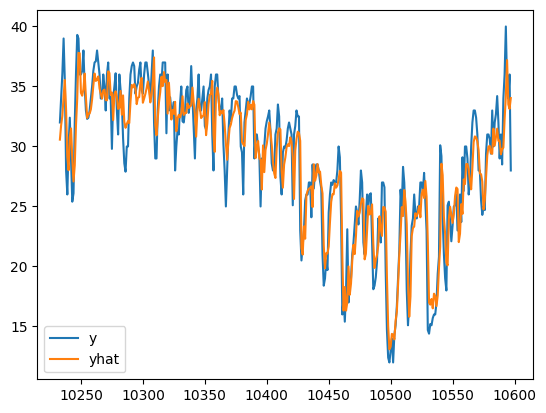

In [53]:
cv[["y", "yhat"]][-365:].plot()

#Test on test dataset

In [84]:
# Predict one day ahead with high accuracy
m = fit_prophet(weather)
forecast_test = predict(test)

DEBUG:cmdstanpy:input tempfile: /tmp/tmp48cuqejq/1zknhtqu.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp48cuqejq/ixm0wa_5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=22715', 'data', 'file=/tmp/tmp48cuqejq/1zknhtqu.json', 'init=/tmp/tmp48cuqejq/ixm0wa_5.json', 'output', 'file=/tmp/tmp48cuqejq/prophet_model8m4it7aq/prophet_model-20240516080748.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:07:48 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:07:50 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [85]:
forecast_test.index = test.index
forecast_test["actual"] = test["y"]
forecast_test

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,cloudcover,...,windspeed_lower,windspeed_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat,actual
datetime,,,,,,,,,,,,,,,,,,,,,
2024-04-30,2024-04-30,26.728334,31.304741,36.822075,26.728334,26.728334,7.353089,7.353089,7.353089,0.377508,...,-0.293804,-0.293804,0.137787,0.137787,0.137787,0.0,0.0,0.0,34.081423,28.0
2024-05-01,2024-05-01,26.728367,26.366122,31.910652,26.728367,26.728367,2.199048,2.199048,2.199048,-0.255108,...,-0.059931,-0.059931,0.163160,0.163160,0.163160,0.0,0.0,0.0,28.927415,26.2
2024-05-02,2024-05-02,26.728400,26.026552,31.367985,26.728400,26.728400,1.998414,1.998414,1.998414,-0.238627,...,0.048011,0.048011,0.186380,0.186380,0.186380,0.0,0.0,0.0,28.726814,27.7
2024-05-03,2024-05-03,26.728433,26.215487,31.868561,26.728433,26.728433,2.267428,2.267428,2.267428,-0.296944,...,-0.293804,-0.293804,0.207624,0.207624,0.207624,0.0,0.0,0.0,28.995860,33.0
2024-05-04,2024-05-04,26.728466,29.365718,34.892250,26.728466,26.728466,5.393005,5.393005,5.393005,-0.026910,...,-0.293804,-0.293804,0.227105,0.227105,0.227105,0.0,0.0,0.0,32.121470,28.7
2024-05-05,2024-05-05,26.728498,27.085739,32.574778,26.728498,26.728498,3.188847,3.188847,3.188847,-0.184113,...,0.048011,0.048011,0.245062,0.245062,0.245062,0.0,0.0,0.0,29.917346,28.8
2024-05-06,2024-05-06,26.728531,27.724828,33.219902,26.728531,26.728531,3.772811,3.772811,3.772811,-0.118189,...,0.048011,0.048011,0.261757,0.261757,0.261757,0.0,0.0,0.0,30.501343,30.4
2024-05-07,2024-05-07,26.728564,29.112477,34.512589,26.728564,26.728564,4.956031,4.956031,4.956031,-0.138473,...,0.263894,0.263894,0.277467,0.277467,0.277467,0.0,0.0,0.0,31.684595,30.0
2024-05-08,2024-05-08,26.728597,29.126964,34.397901,26.728597,26.728597,5.075643,5.075643,5.075643,-0.137205,...,0.155952,0.155952,0.292476,0.292476,0.292476,0.0,0.0,0.0,31.804240,31.0


Các thông số lỗi để đánh giá sức mạnh của mô hình so với mô hình khác

In [86]:
mse(forecast_test)
mae(forecast_test)
mape(forecast_test)

5.6225083423284365
1.8354778883008545
MAPE: 6.20%


Dự đoán tương lai khi không có thêm các regressor

In [87]:
# Predict multiple days ahead with lower accuracy
m = Prophet(changepoint_prior_scale = 0.002,daily_seasonality=False, weekly_seasonality= False, yearly_seasonality=True)
m.fit(weather)
future = m.make_future_dataframe(periods=14)
#future = future.set_index('ds',inplace = True)
forecast = predict(future)

DEBUG:cmdstanpy:input tempfile: /tmp/tmp48cuqejq/a8v9z9gc.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp48cuqejq/eut8fm4k.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=88482', 'data', 'file=/tmp/tmp48cuqejq/a8v9z9gc.json', 'init=/tmp/tmp48cuqejq/eut8fm4k.json', 'output', 'file=/tmp/tmp48cuqejq/prophet_modeltjyoogrc/prophet_model-20240516080809.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:08:09 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:08:10 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [88]:
from prophet.plot import plot_plotly

plot_plotly(m, forecast)